In [1]:
# Credit to sources in top lines
# from https://www.kaggle.com/code/mrankitgupta/spotify-data-analysis-using-python
# and from # https://github.com/enjuichang/PracticalDataScience-ENCA

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

# import for recommendation
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# setting up the credentials
client_id = "2ca89022ac6348b99eb6e5cb99583158"
client_secret = "4dd5feb53234451f9952db292972a656"
auth_url = 'https://accounts.spotify.com/api/token'

os.environ['SPOTIPY_CLIENT_ID'] = client_id
os.environ['SPOTIPY_CLIENT_SECRET'] = client_secret
os.environ['SPOTIPY_REDIRECT_URI'] = 'http://localhost:1410/'

data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
    'scope': 'user-top-read'
}

# get access token
auth_response = requests.post(auth_url, data=data)
access_token = auth_response.json().get('access_token')

In [2]:
# Request top tracks data and create top tracks dataframe

# set up authorisation for user data
scope = "user-top-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

# https://www.linkedin.com/pulse/analyse-your-spotify-data-python-spotipy-shai-nisan-ph-d-/
user_top_tracks = sp.current_user_top_tracks(limit=50)
user_top_tracks2 = sp.current_user_top_tracks(limit=50, offset = 50)

# Create lists for future iteration
top_track_ids = []
top_track_titles = []

for i in user_top_tracks['items']:
    top_track_ids.append(i['id'])
    top_track_titles.append(i['name'])

# Create a dataframe
top_features = sp.audio_features(top_track_ids)
top_features_df = pd.DataFrame(data=top_features, columns=top_features[0].keys())
top_features_df.drop(columns=["type", "id","uri","track_href", "analysis_url", "time_signature"], inplace=True)

top_features_df.head()



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.399,0.7610,9,-6.318,1,0.0334,0.000105,0.0456,0.0757,0.2430,140.084,304907
1,0.252,0.1880,1,-11.648,1,0.0456,0.329000,0.1210,0.1000,0.0302,86.997,113773
2,0.404,0.4070,5,-11.843,1,0.0299,0.492000,0.0338,0.3910,0.0848,106.547,189293
3,0.430,0.2560,2,-15.737,1,0.0607,0.161000,0.8520,0.1470,0.2080,96.704,330905
4,0.213,0.0695,11,-14.832,1,0.0409,0.018500,0.9580,0.1240,0.0382,112.192,106213


In [3]:
# Func to store daily mix info, returns dataframe with 'features'
# https://medium.com/codex/decoding-spotify-daily-mix-73f4783037b4

scope = "user-read-recently-played"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

def fetch_daily_mix(id):

    result = sp.playlist(id)

    track_ids = []

    # get tracks by id
    for i in result['tracks']['items']:
        track = i['track']
        track_ids.append(track['id'])

    features = sp.audio_features(track_ids)
    df = pd.DataFrame(data=features, columns=features[0].keys())
    # drop unneccessary columns
    df.drop(columns=["type", "id","uri","track_href", "analysis_url", "time_signature"], inplace=True)

    return df

In [4]:
# Manually input daily mix playlists, as the API doesn't support a call
# Then combine data
# Daily mixes accessed on 9/4/24

#indie Mix
#https://open.spotify.com/playlist/37i9dQZF1EQqkOPvHGajmW?si=fcdcd0544f99465d
indie_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQqkOPvHGajmW?si=fcdcd0544f99465d")

#dance/electronic mix
#https://open.spotify.com/playlist/37i9dQZF1EQp9BVPsNVof1?si=7137873e4b1547b9
dance_electronic_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQp9BVPsNVof1?si=7137873e4b1547b9")

#chill mix
#https://open.spotify.com/playlist/37i9dQZF1EVHGWrwldPRtj?si=0348a4a3a2974cf3
chill_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EVHGWrwldPRtj?si=0348a4a3a2974cf3")

#upbeat mix
#https://open.spotify.com/playlist/37i9dQZF1EVJHK7Q1TBABQ?si=adf2057ec8184d87
upbeat_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EVJHK7Q1TBABQ?si=adf2057ec8184d87")

#pop mix
#https://open.spotify.com/playlist/37i9dQZF1EQncLwOalG3K7?si=b1bb9edee4e14a3a
pop_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQncLwOalG3K7?si=b1bb9edee4e14a3a")

#folk & acoustic mix
#https://open.spotify.com/playlist/37i9dQZF1EQp62d3Dl7ECY?si=072b53072c9d4a8a
folk_acoustic_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQp62d3Dl7ECY?si=072b53072c9d4a8a")

# give the source name for each dataframe
indie_mix['source'] = 'Indie Mix'
dance_electronic_mix['source'] = 'Dance/Elec Mix'
chill_mix['source'] = 'Chill Mix'
upbeat_mix['source'] = 'Upbeat Mix'
pop_mix['source'] = 'Pop Mix'
folk_acoustic_mix['source'] = 'Folk/Acoust Mix'
top_features_df['source'] = 'User Top Tracks'

# merge the dataframes together
spotify_df = pd.concat([top_features_df, indie_mix, dance_electronic_mix, chill_mix, upbeat_mix, pop_mix, folk_acoustic_mix])
# set the sns style for the visualization
sns.set_context('poster')
sns.set_style('dark')


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


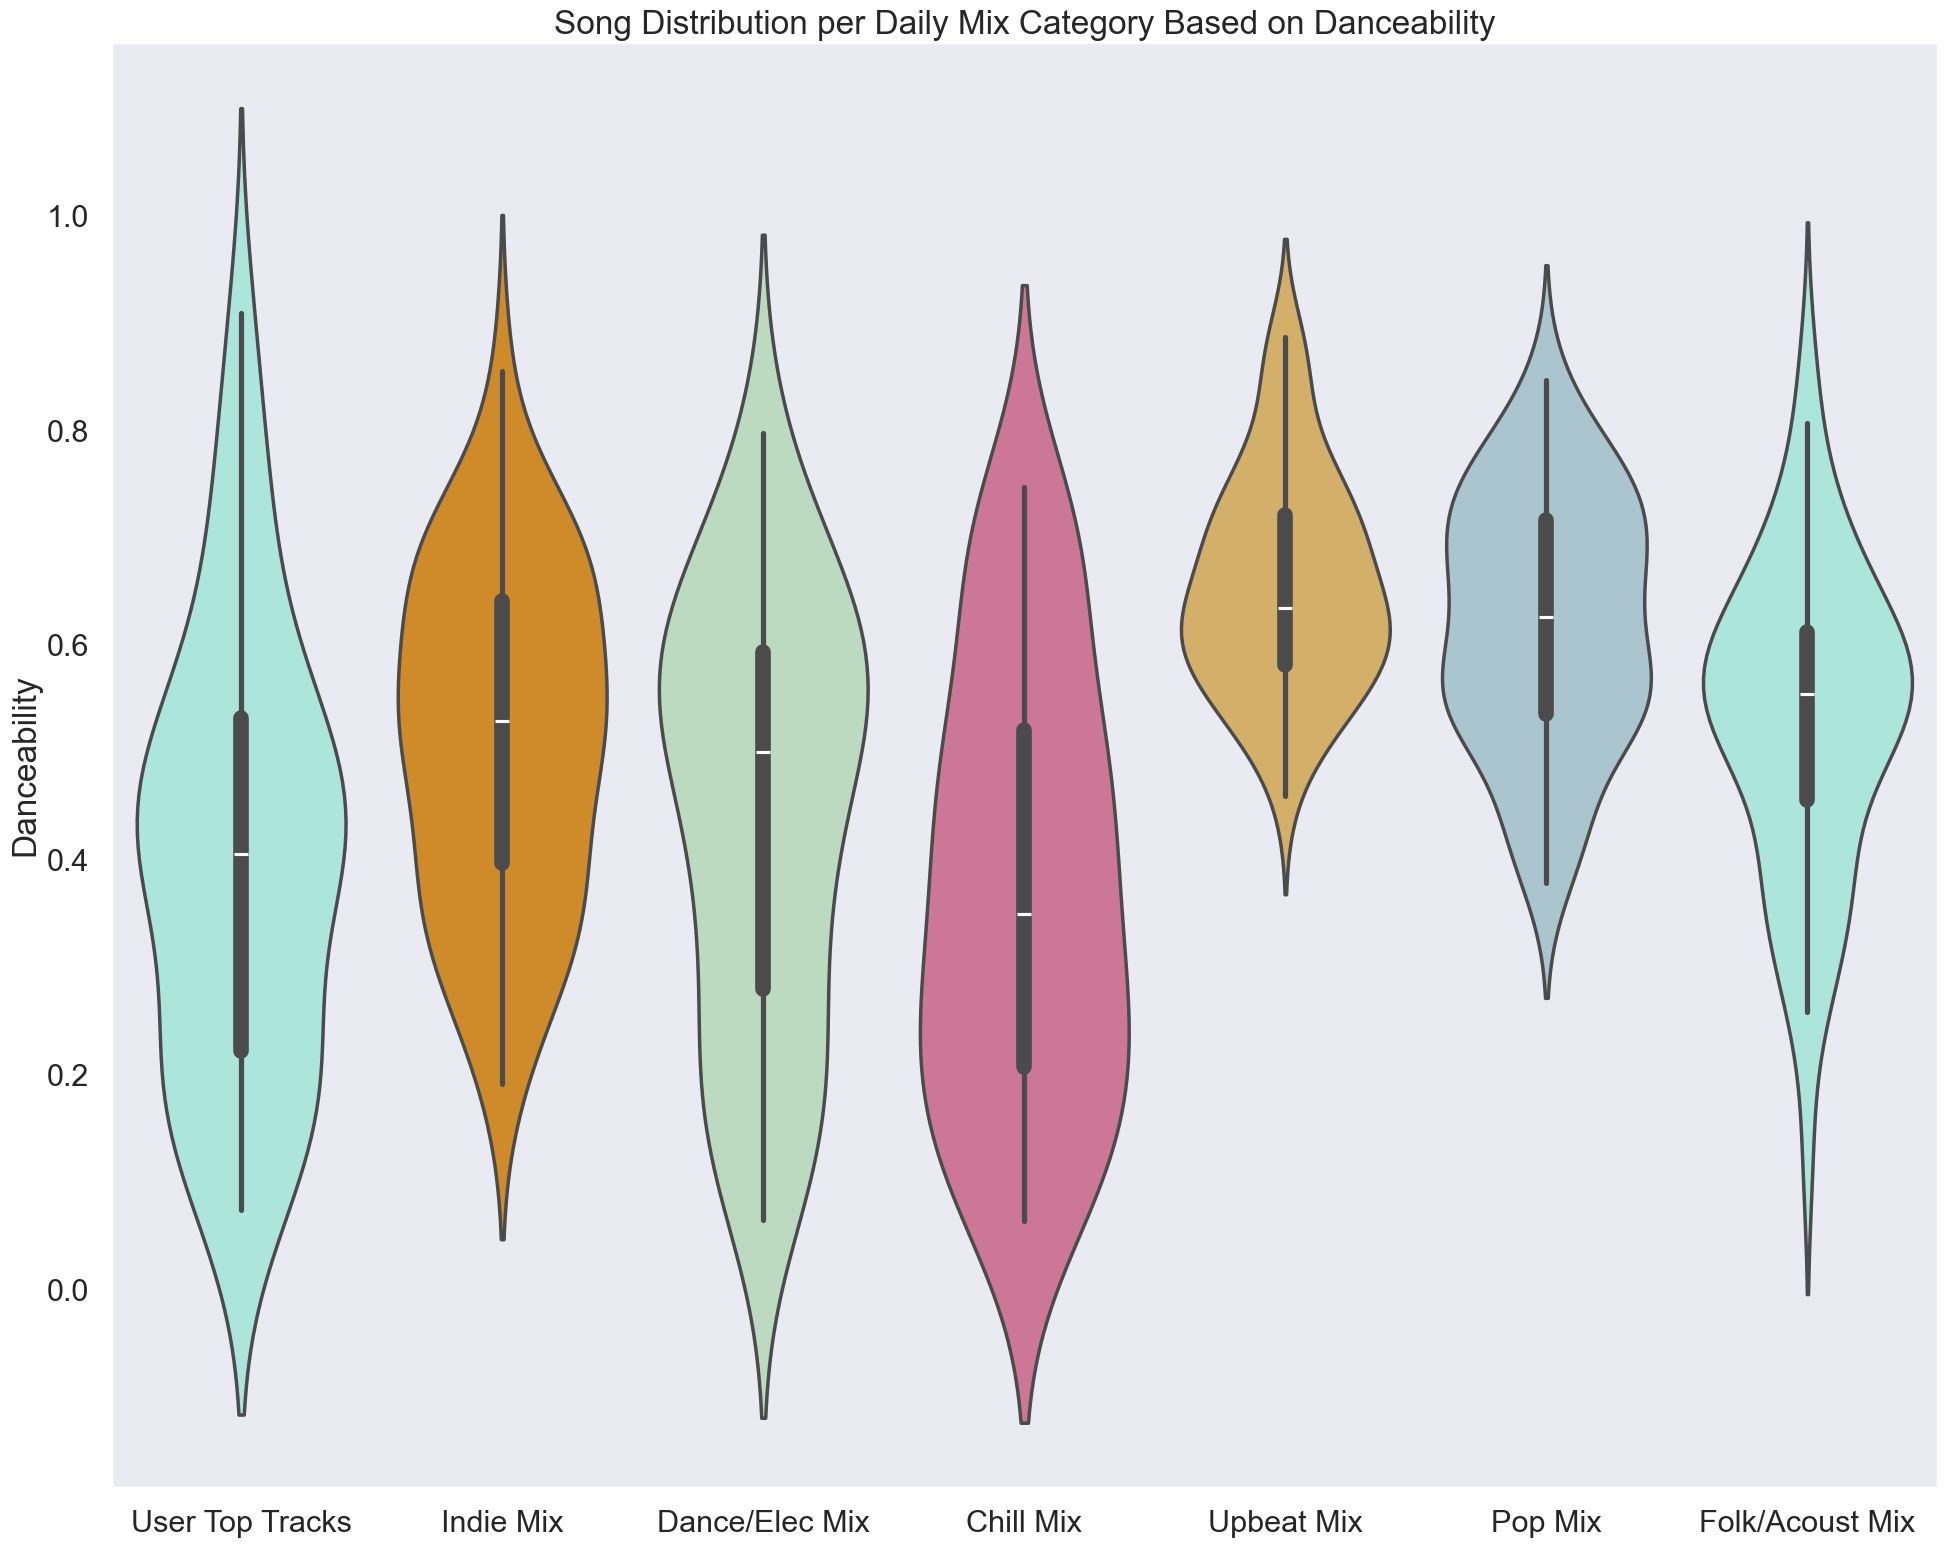

Danceability
Min: 0.0637
Max: 0.91


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


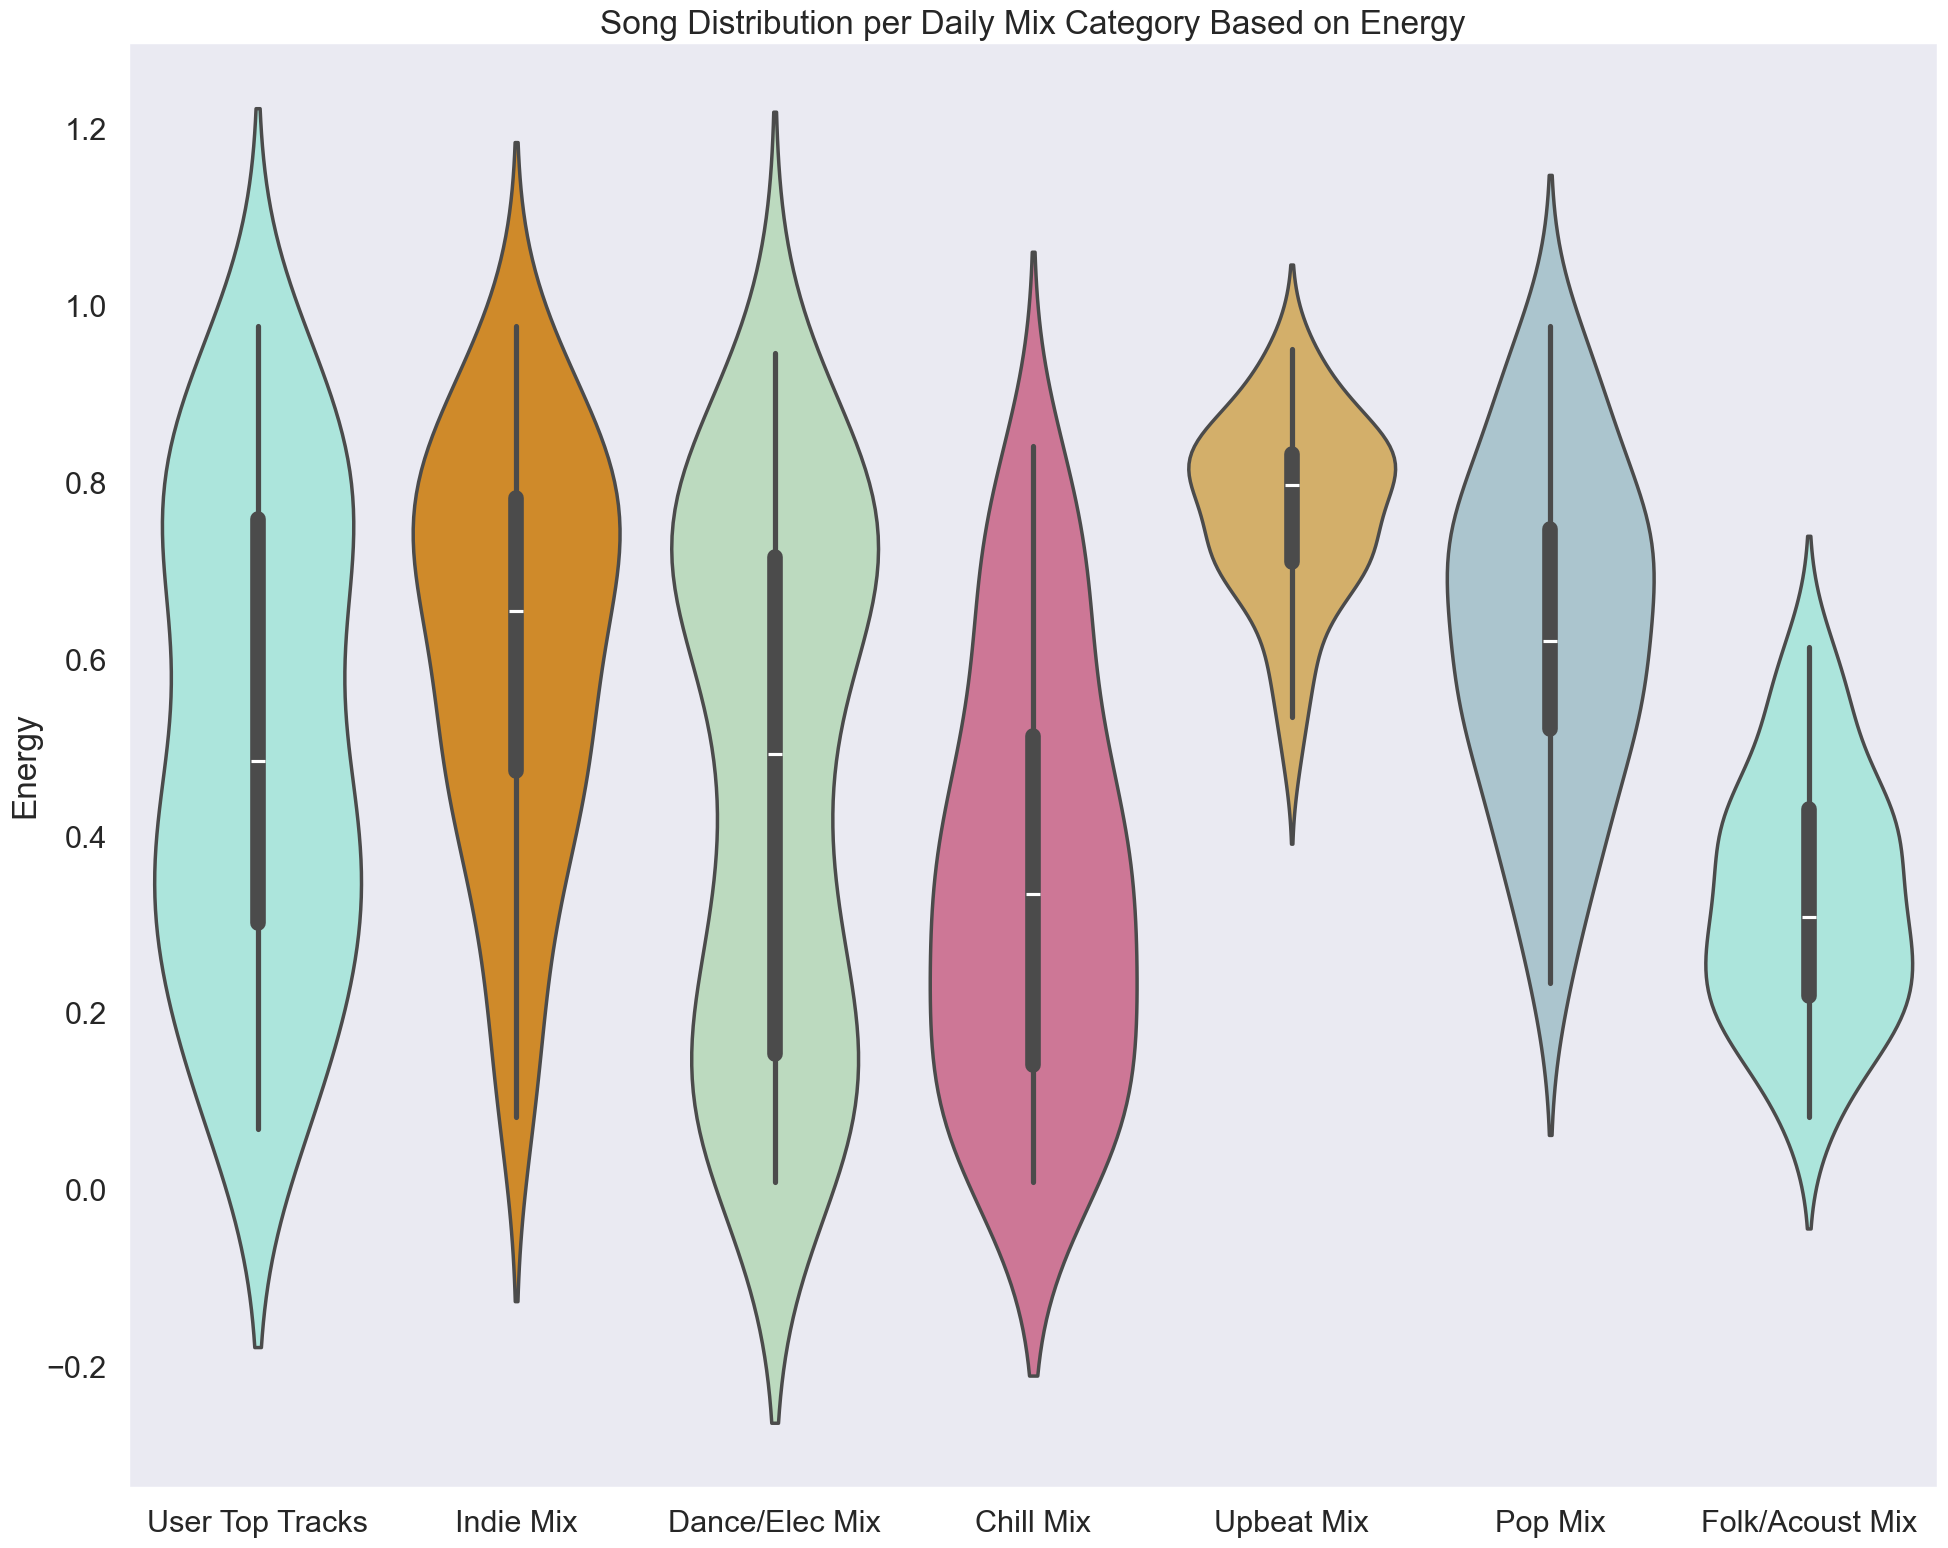

Energy
Min: 0.00995
Max: 0.977


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


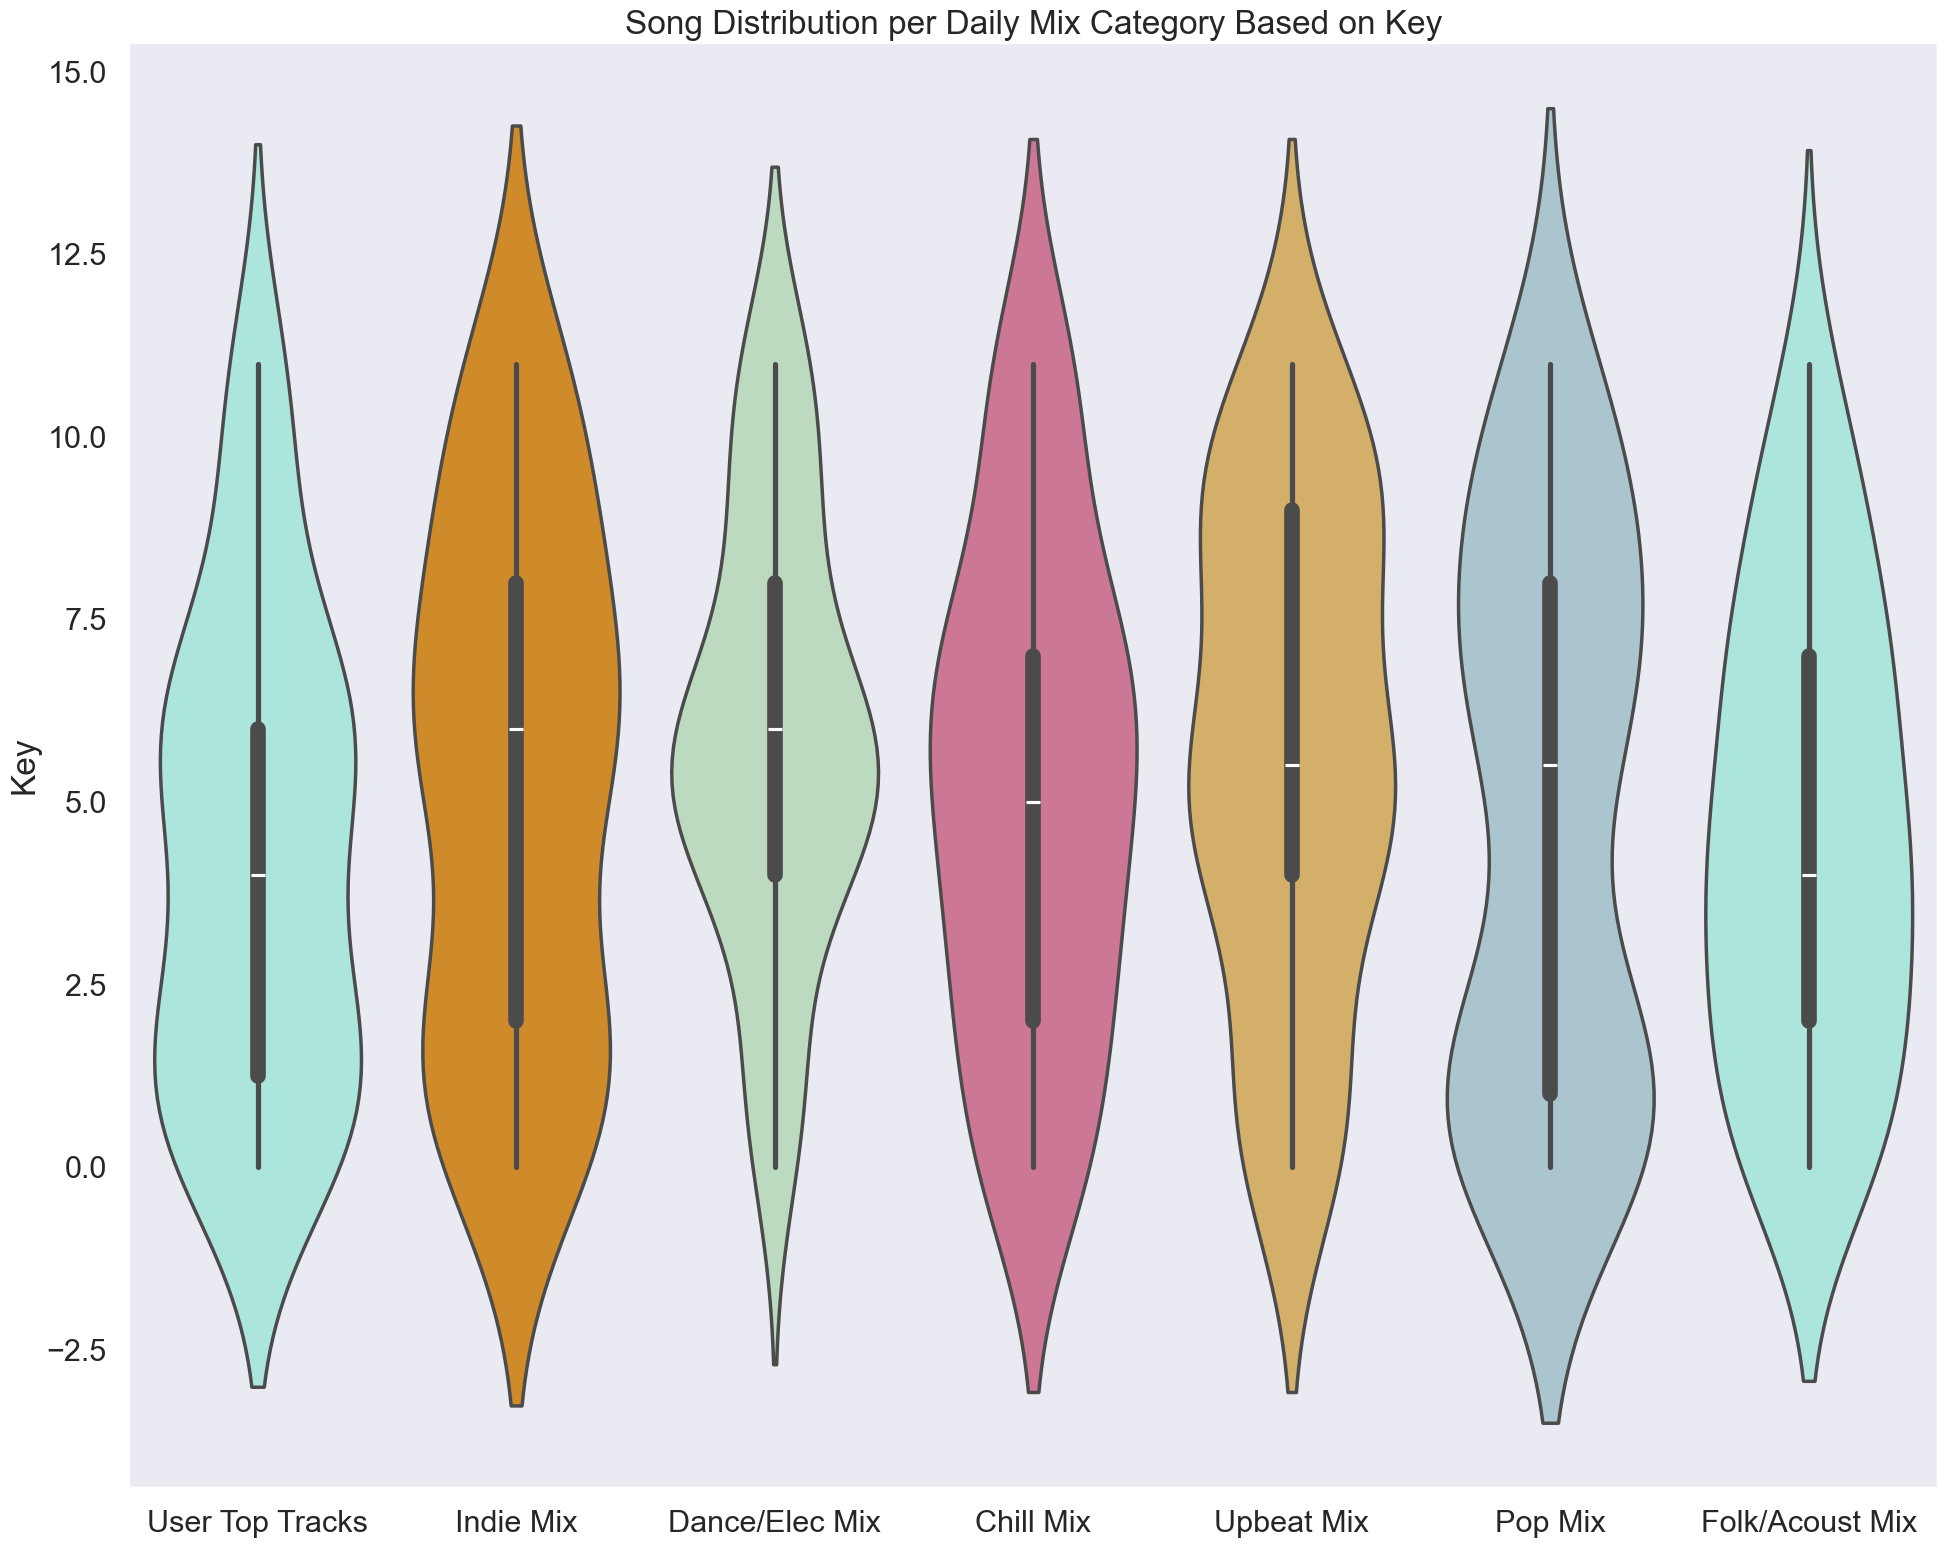

Key
Min: 0
Max: 11


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


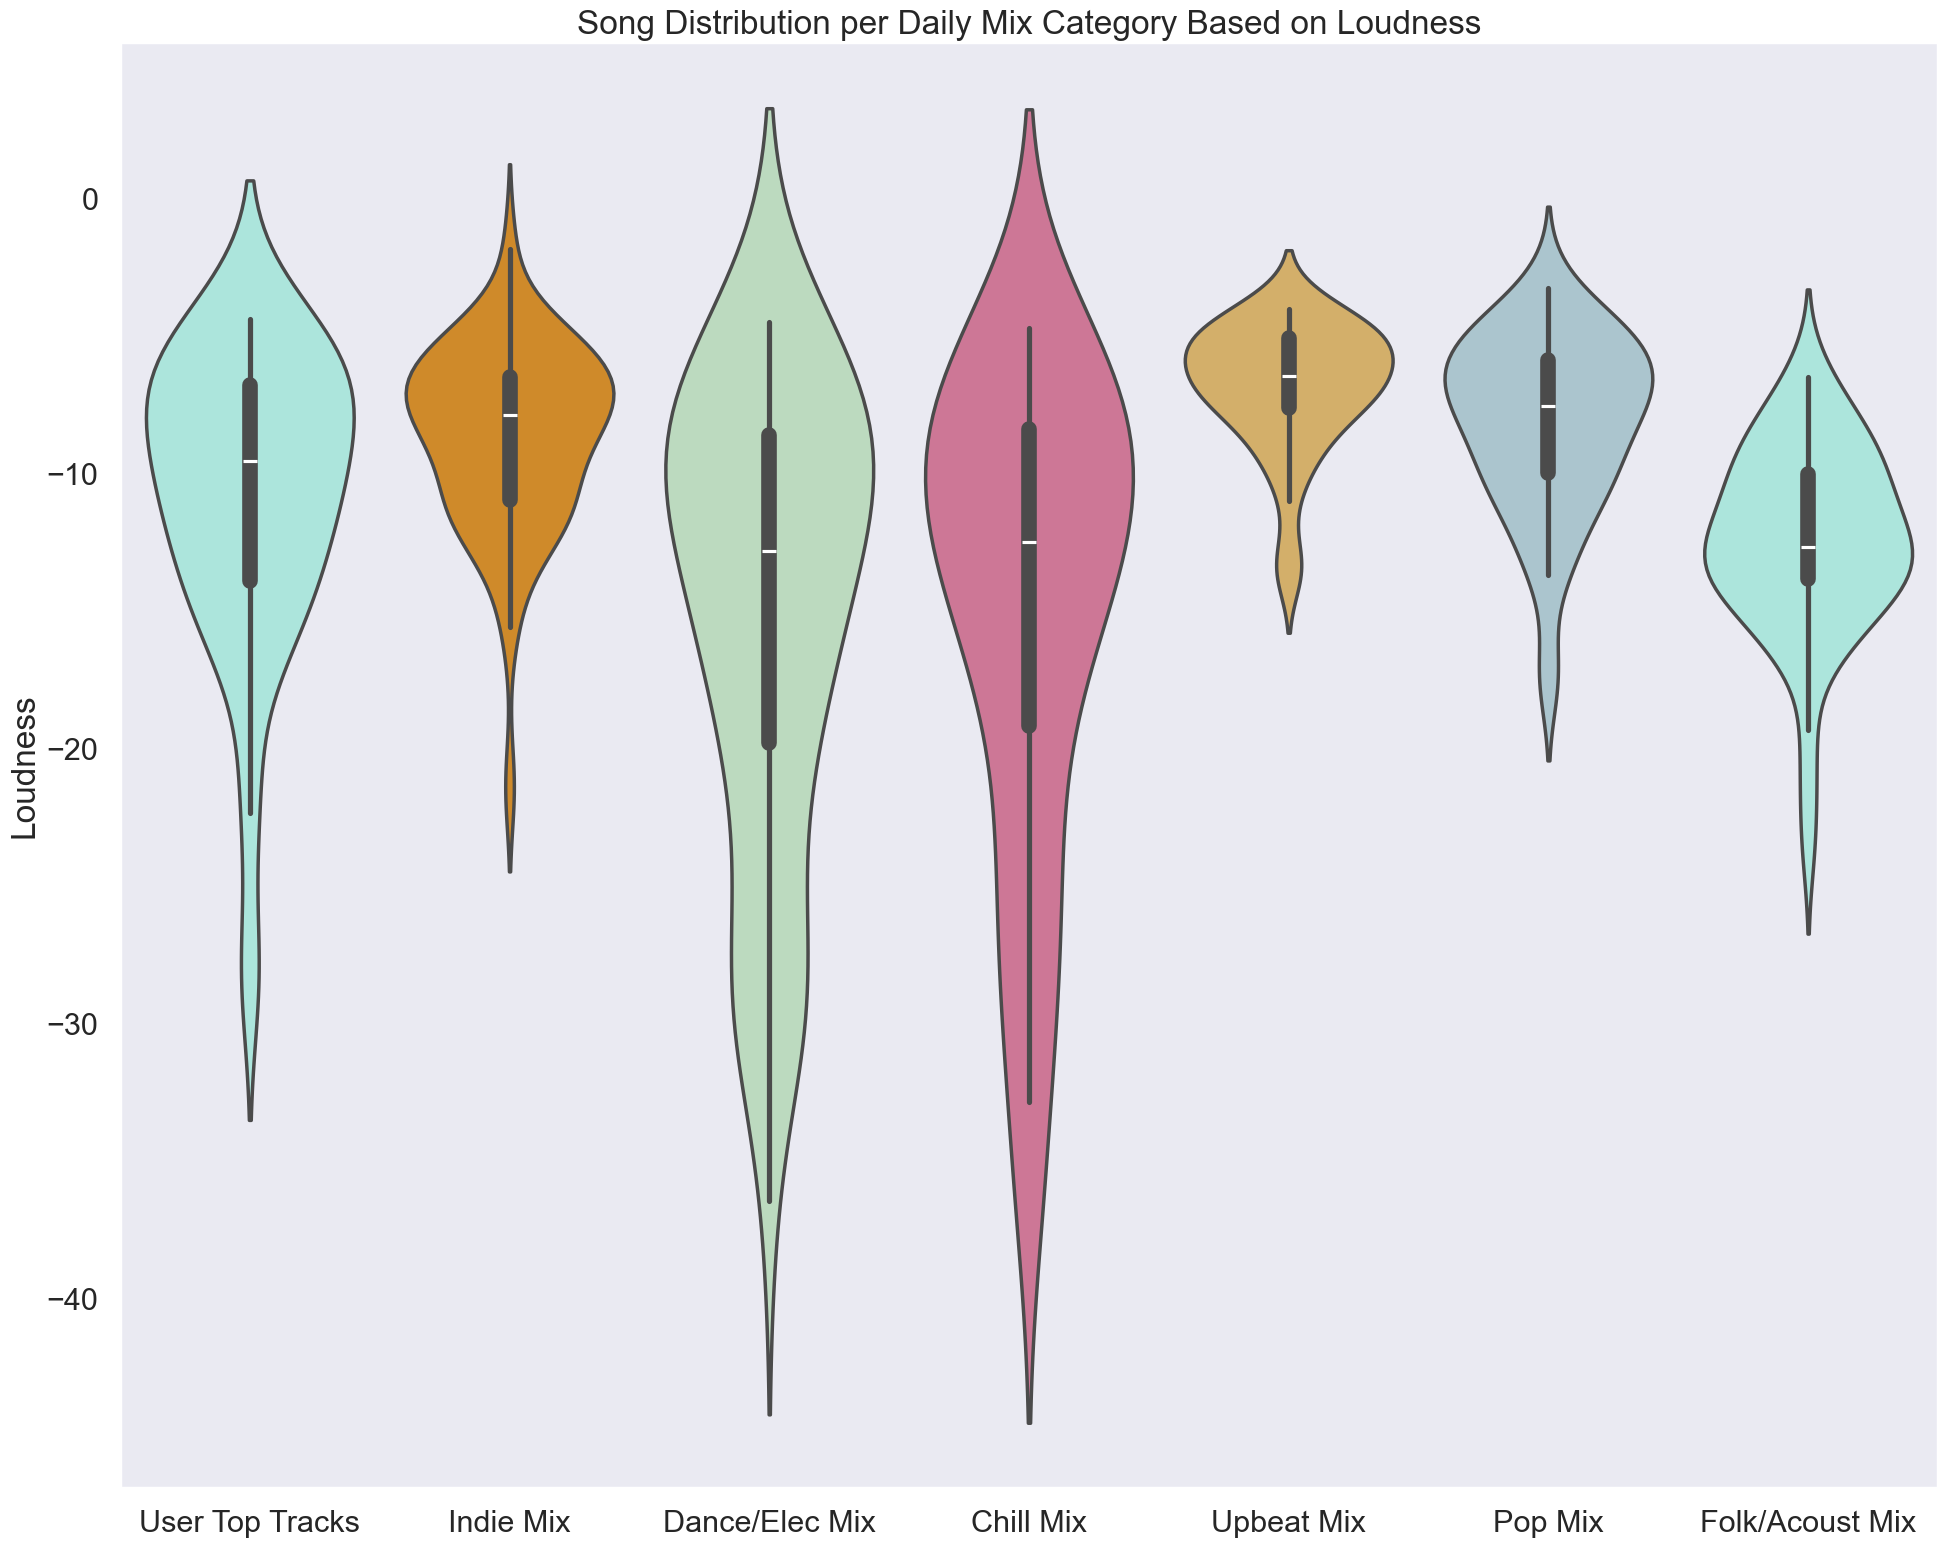

Loudness
Min: -36.528
Max: -1.827


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


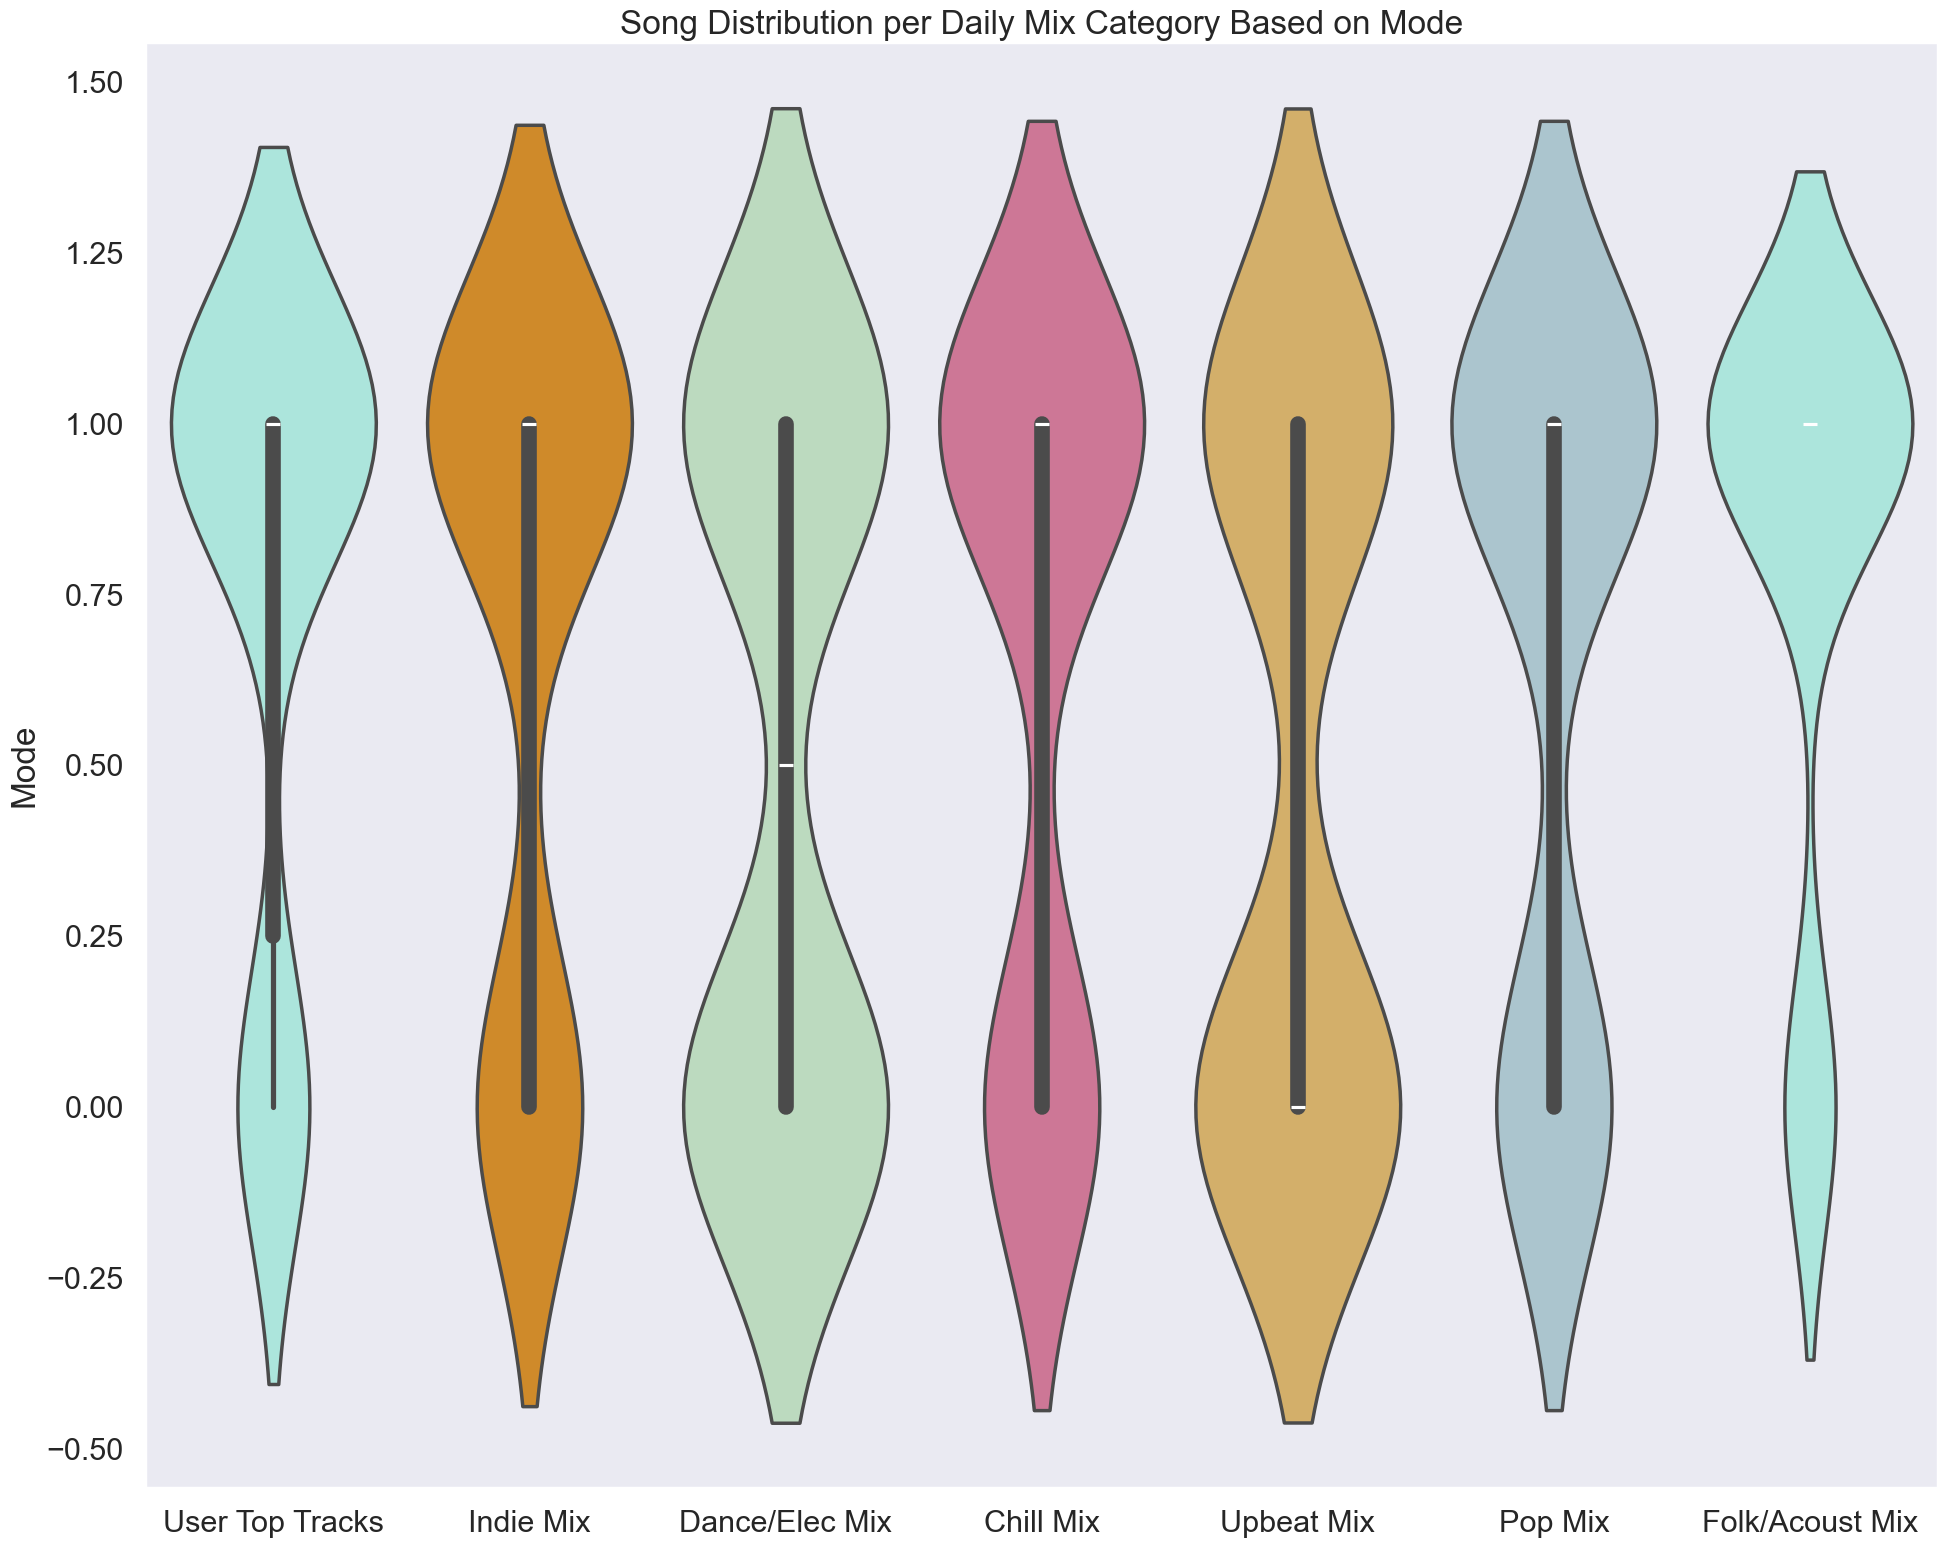

Mode
Min: 0
Max: 1


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


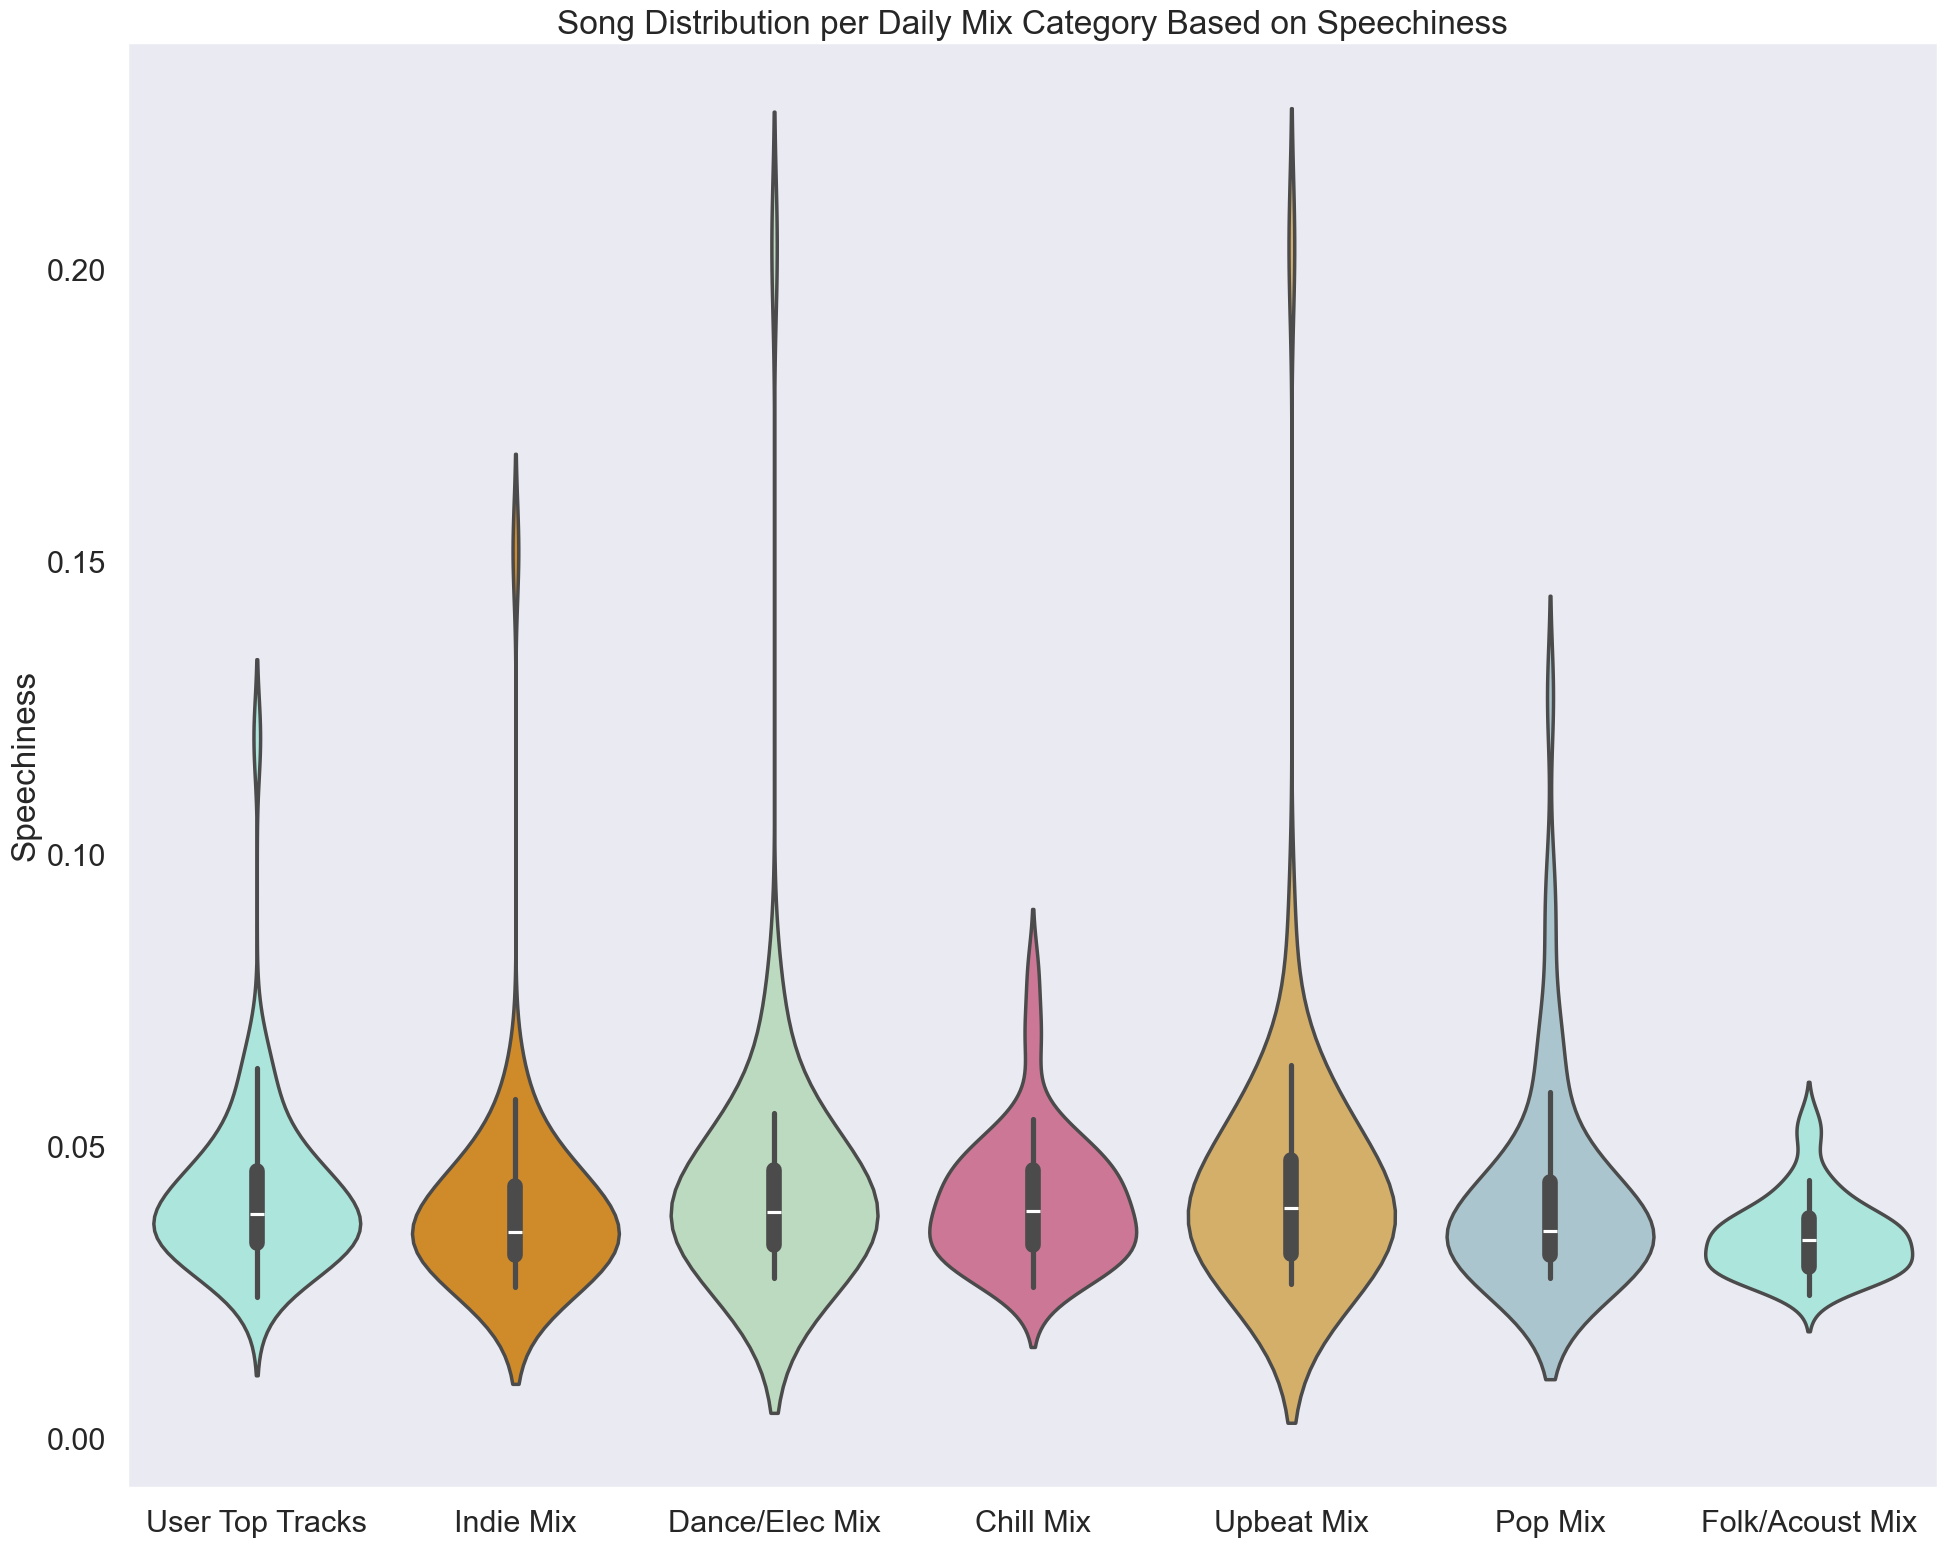

Speechiness
Min: 0.0243
Max: 0.204


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


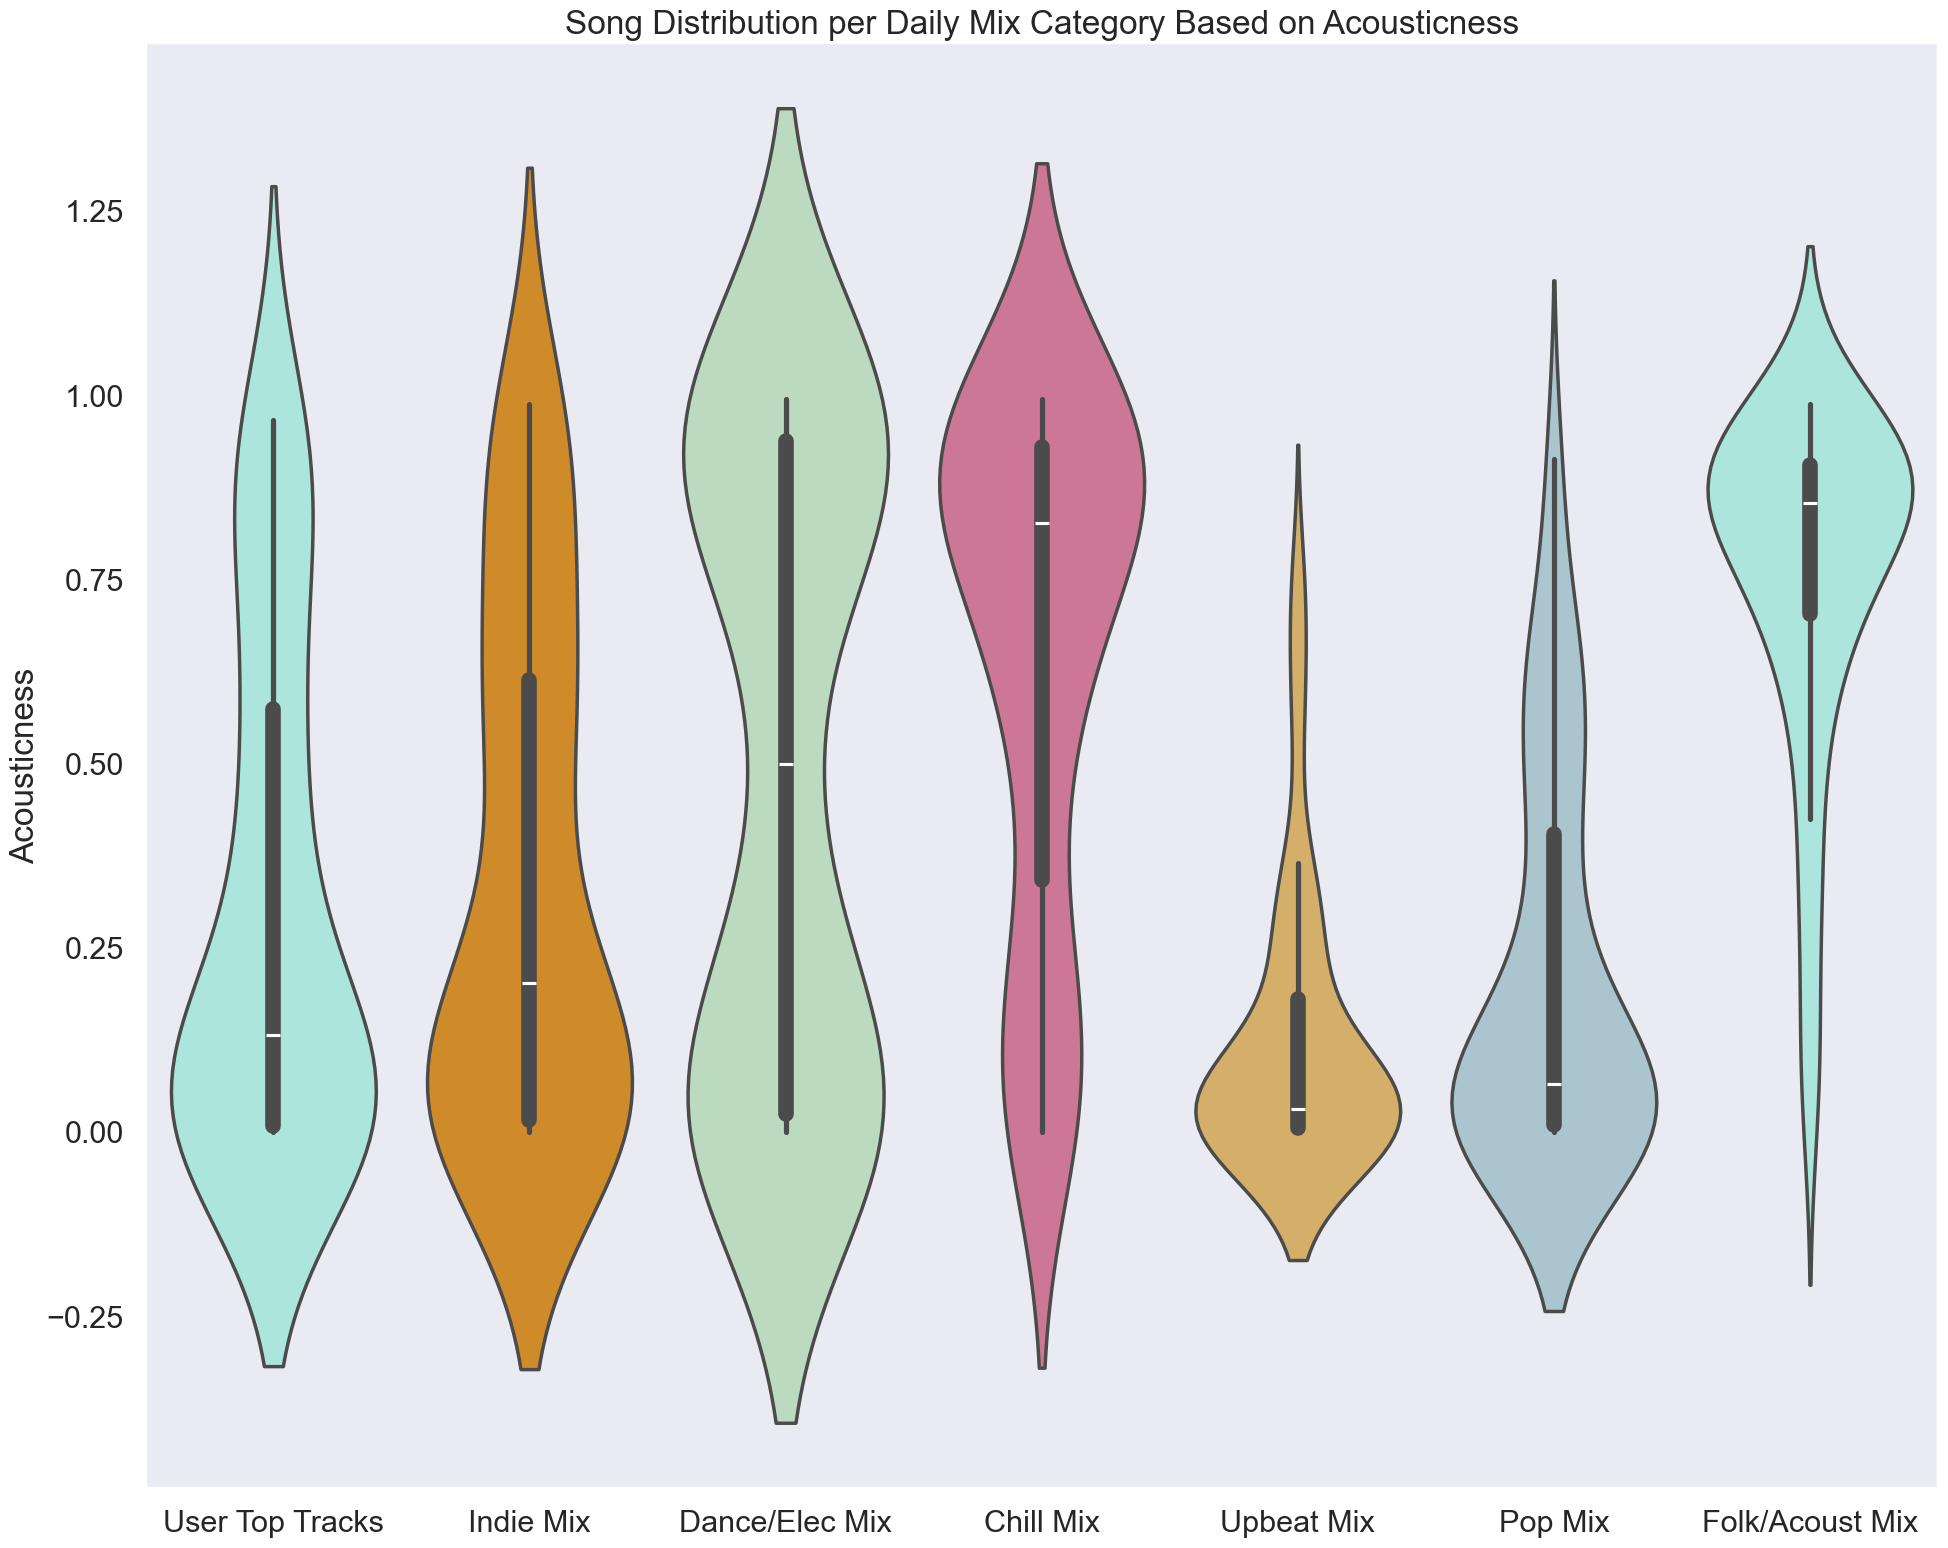

Acousticness
Min: 1.95e-05
Max: 0.996


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


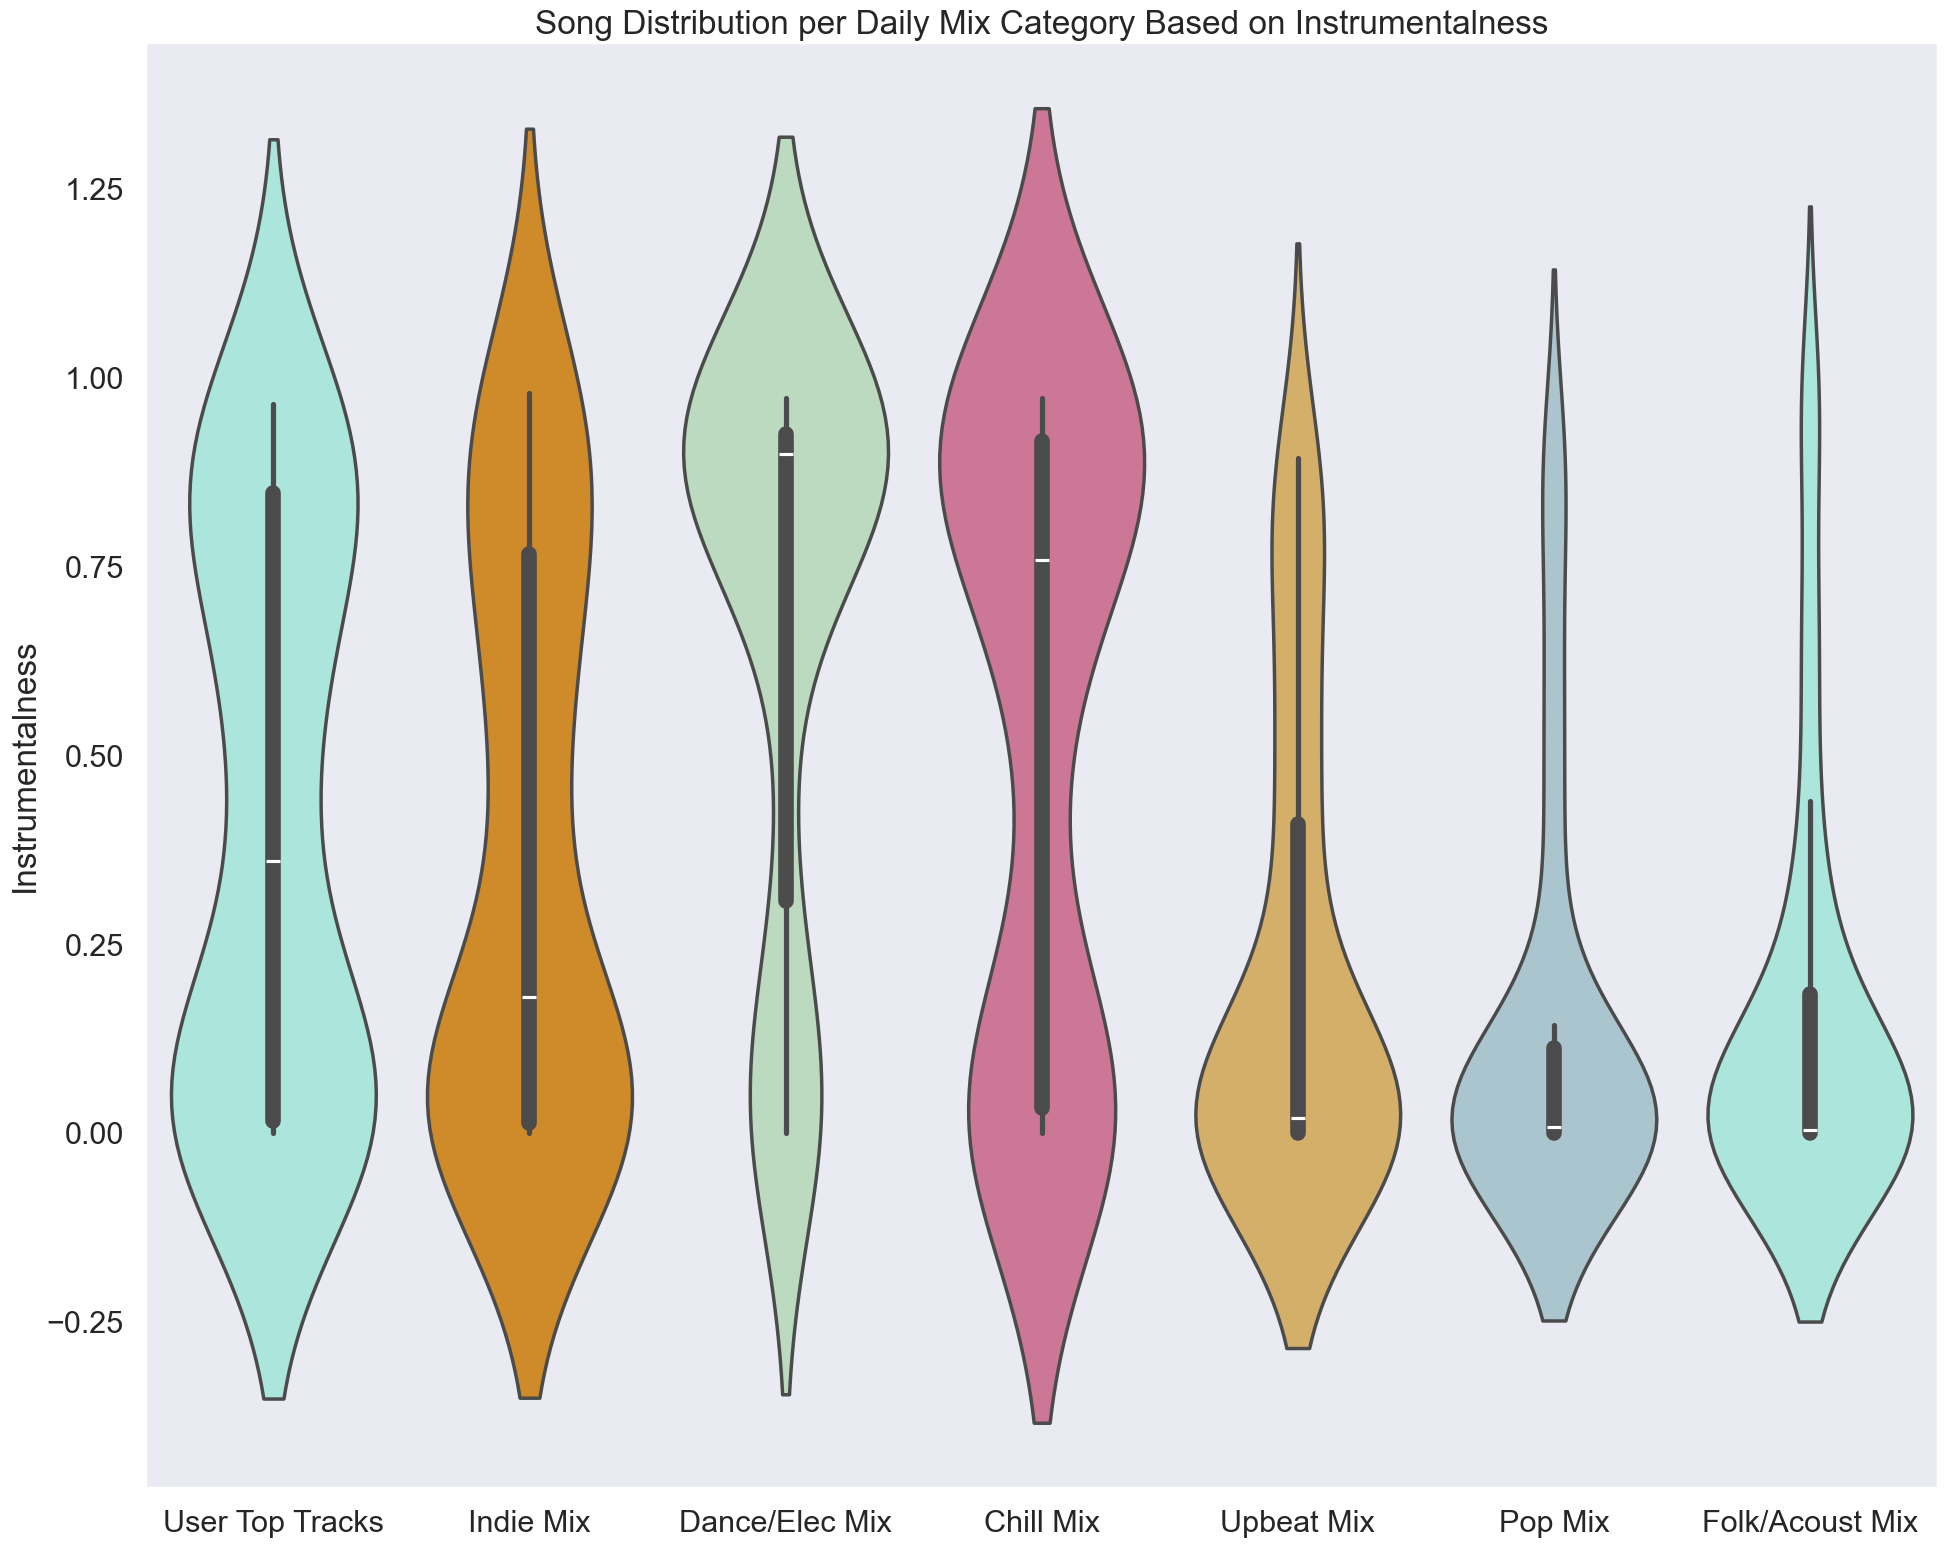

Instrumentalness
Min: 0.0
Max: 0.98


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


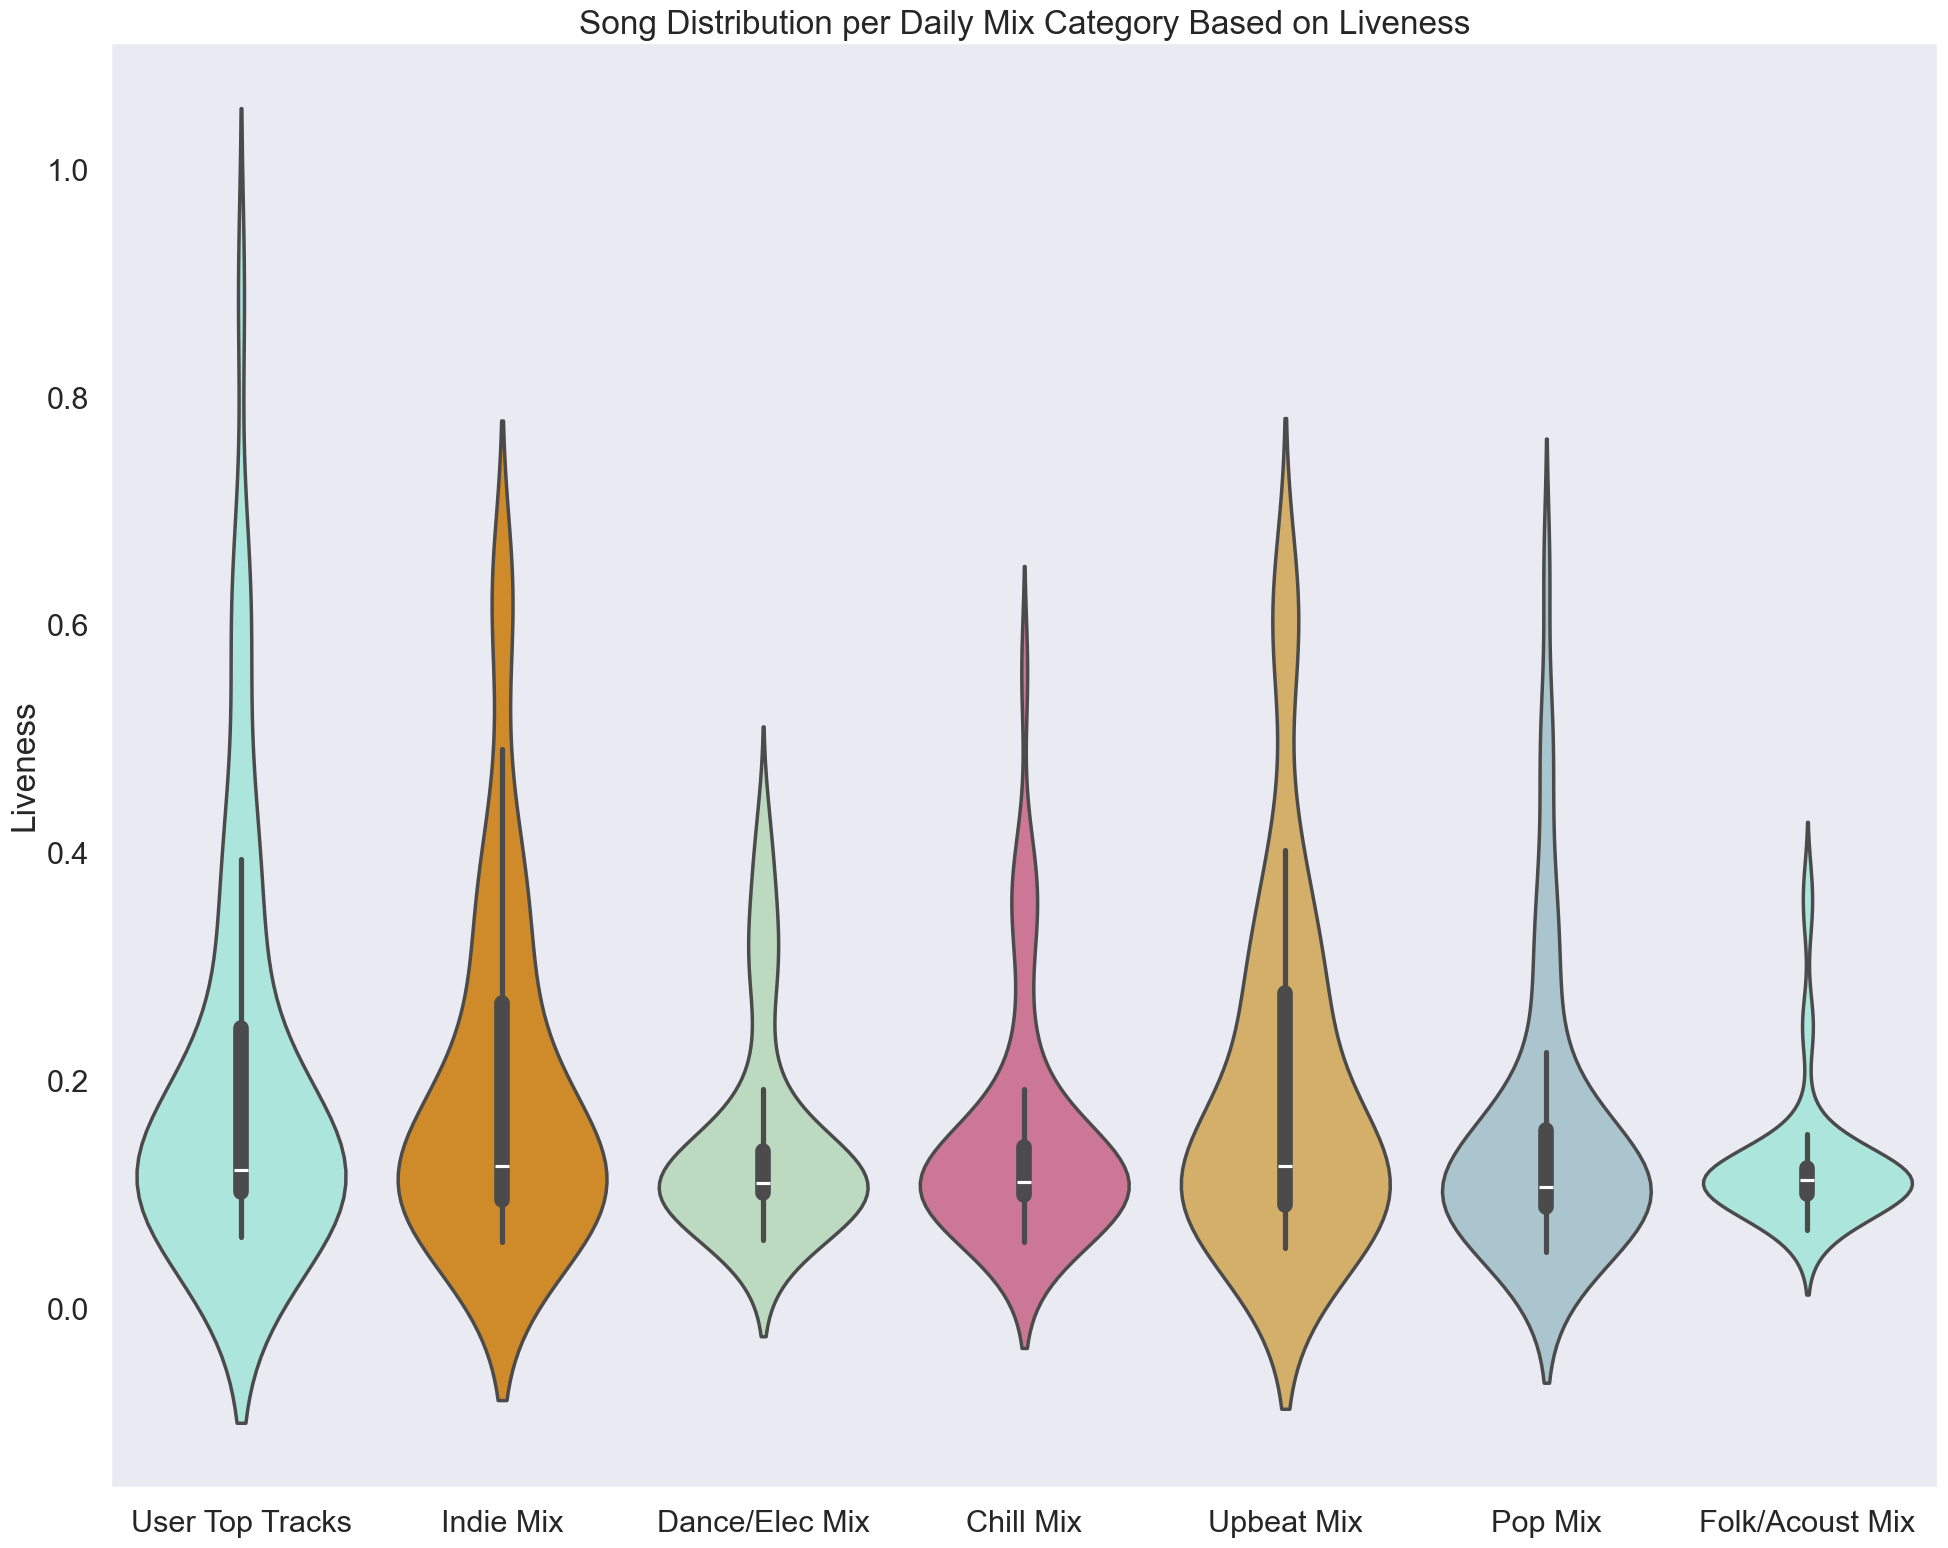

Liveness
Min: 0.0498
Max: 0.891


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


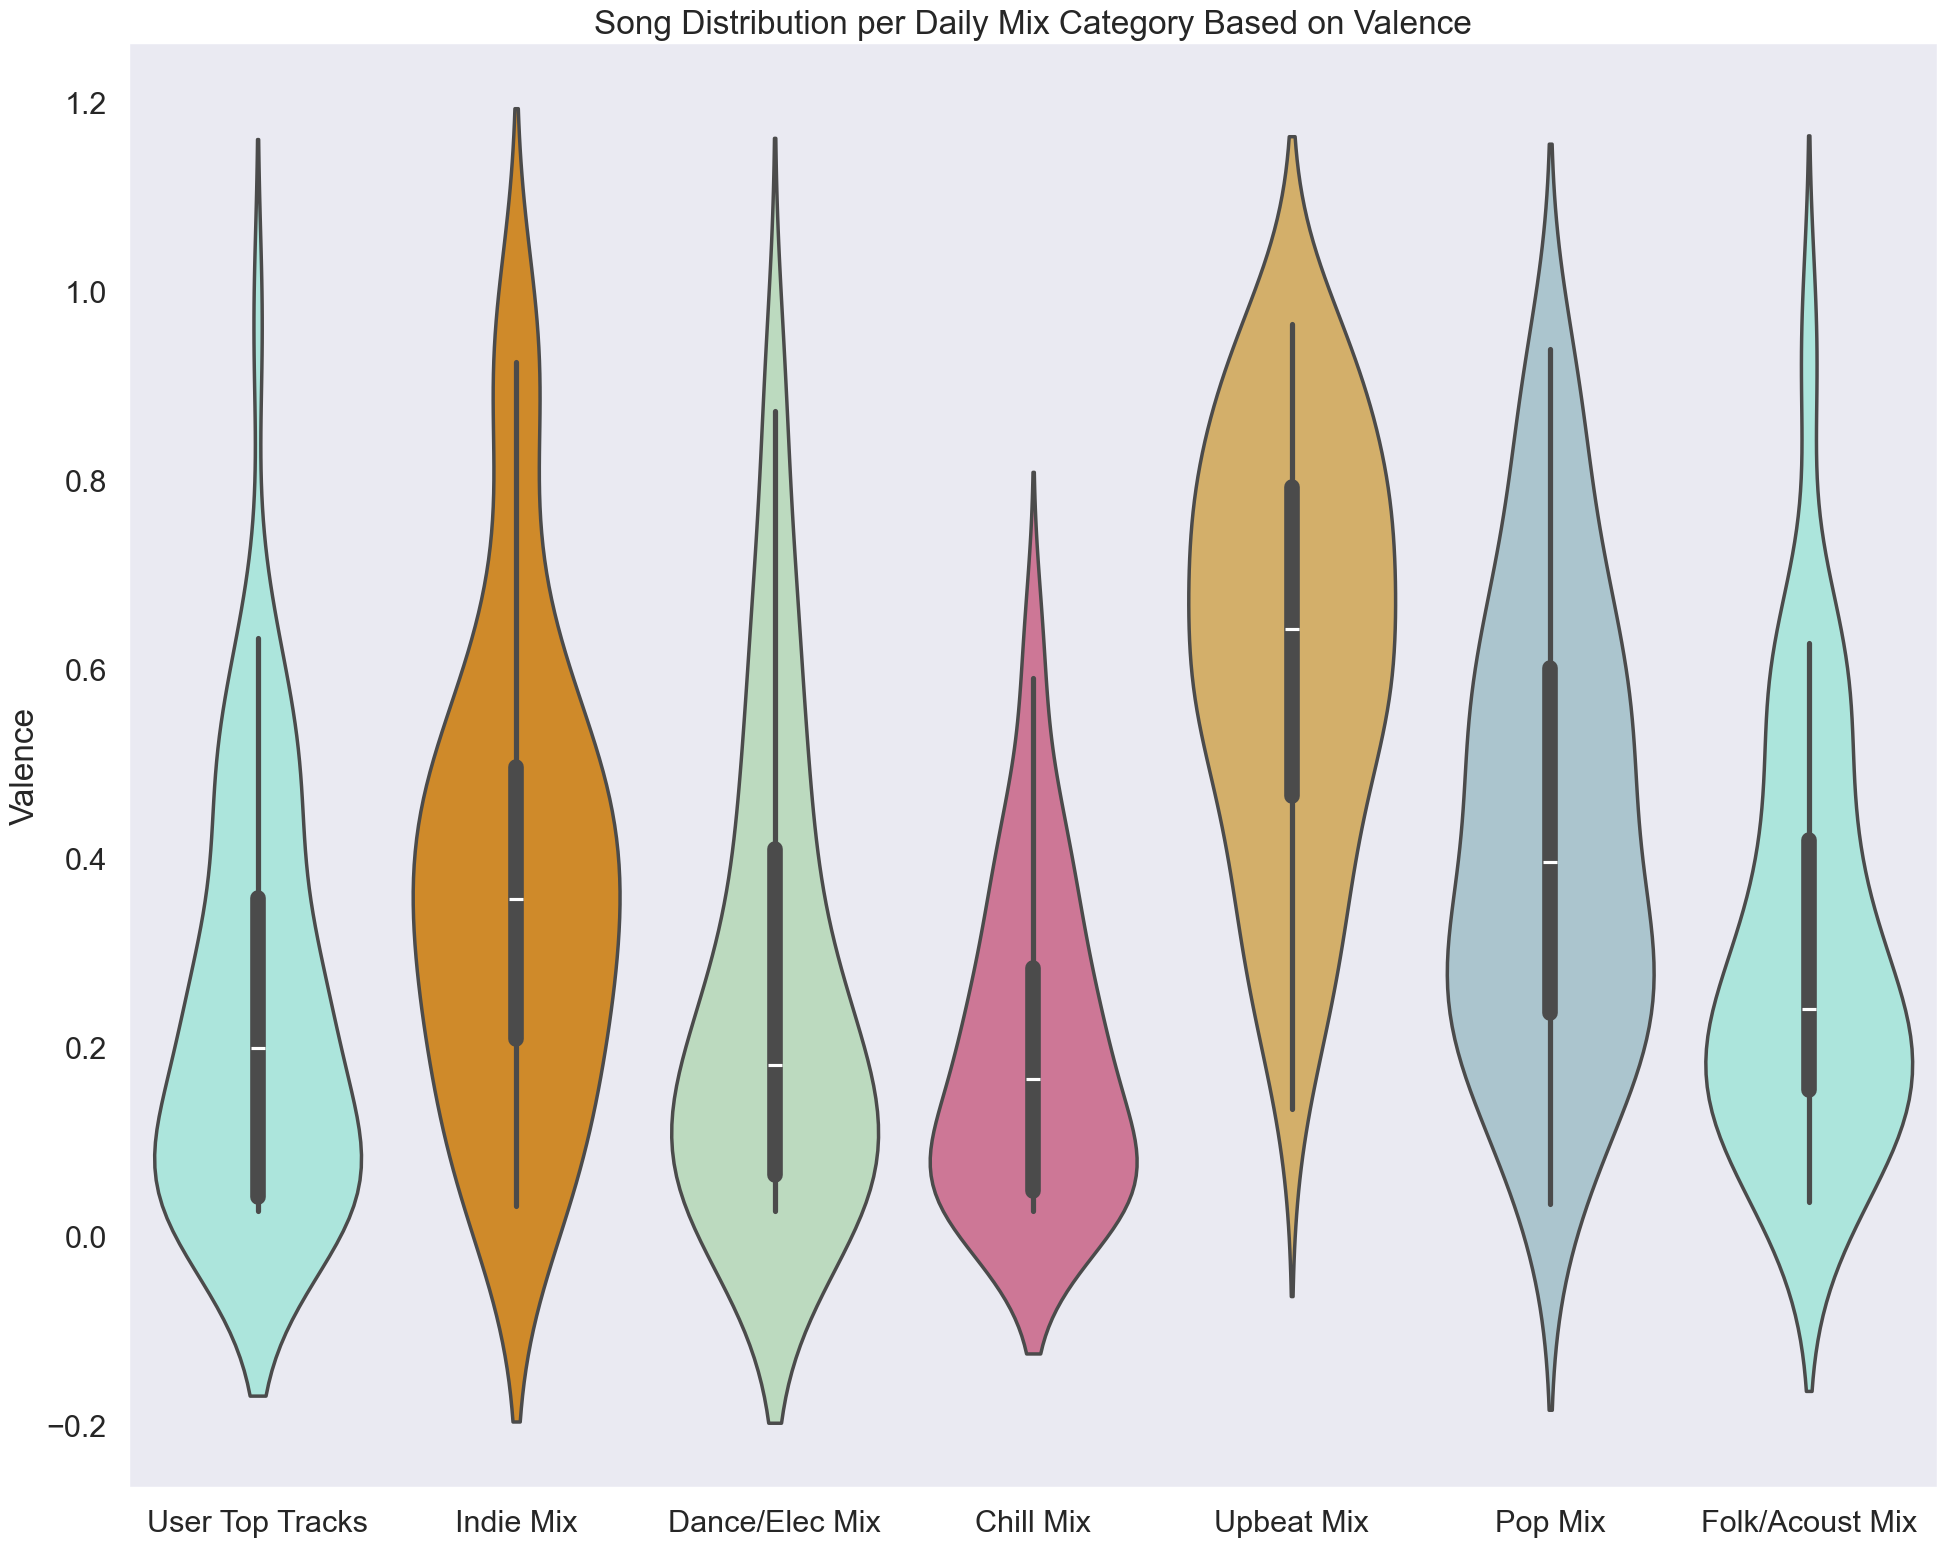

Valence
Min: 0.0273
Max: 0.966


C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
C:\Users\M\AppData\Local\Temp\ipykernel_25948\3039465271.py:9: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)


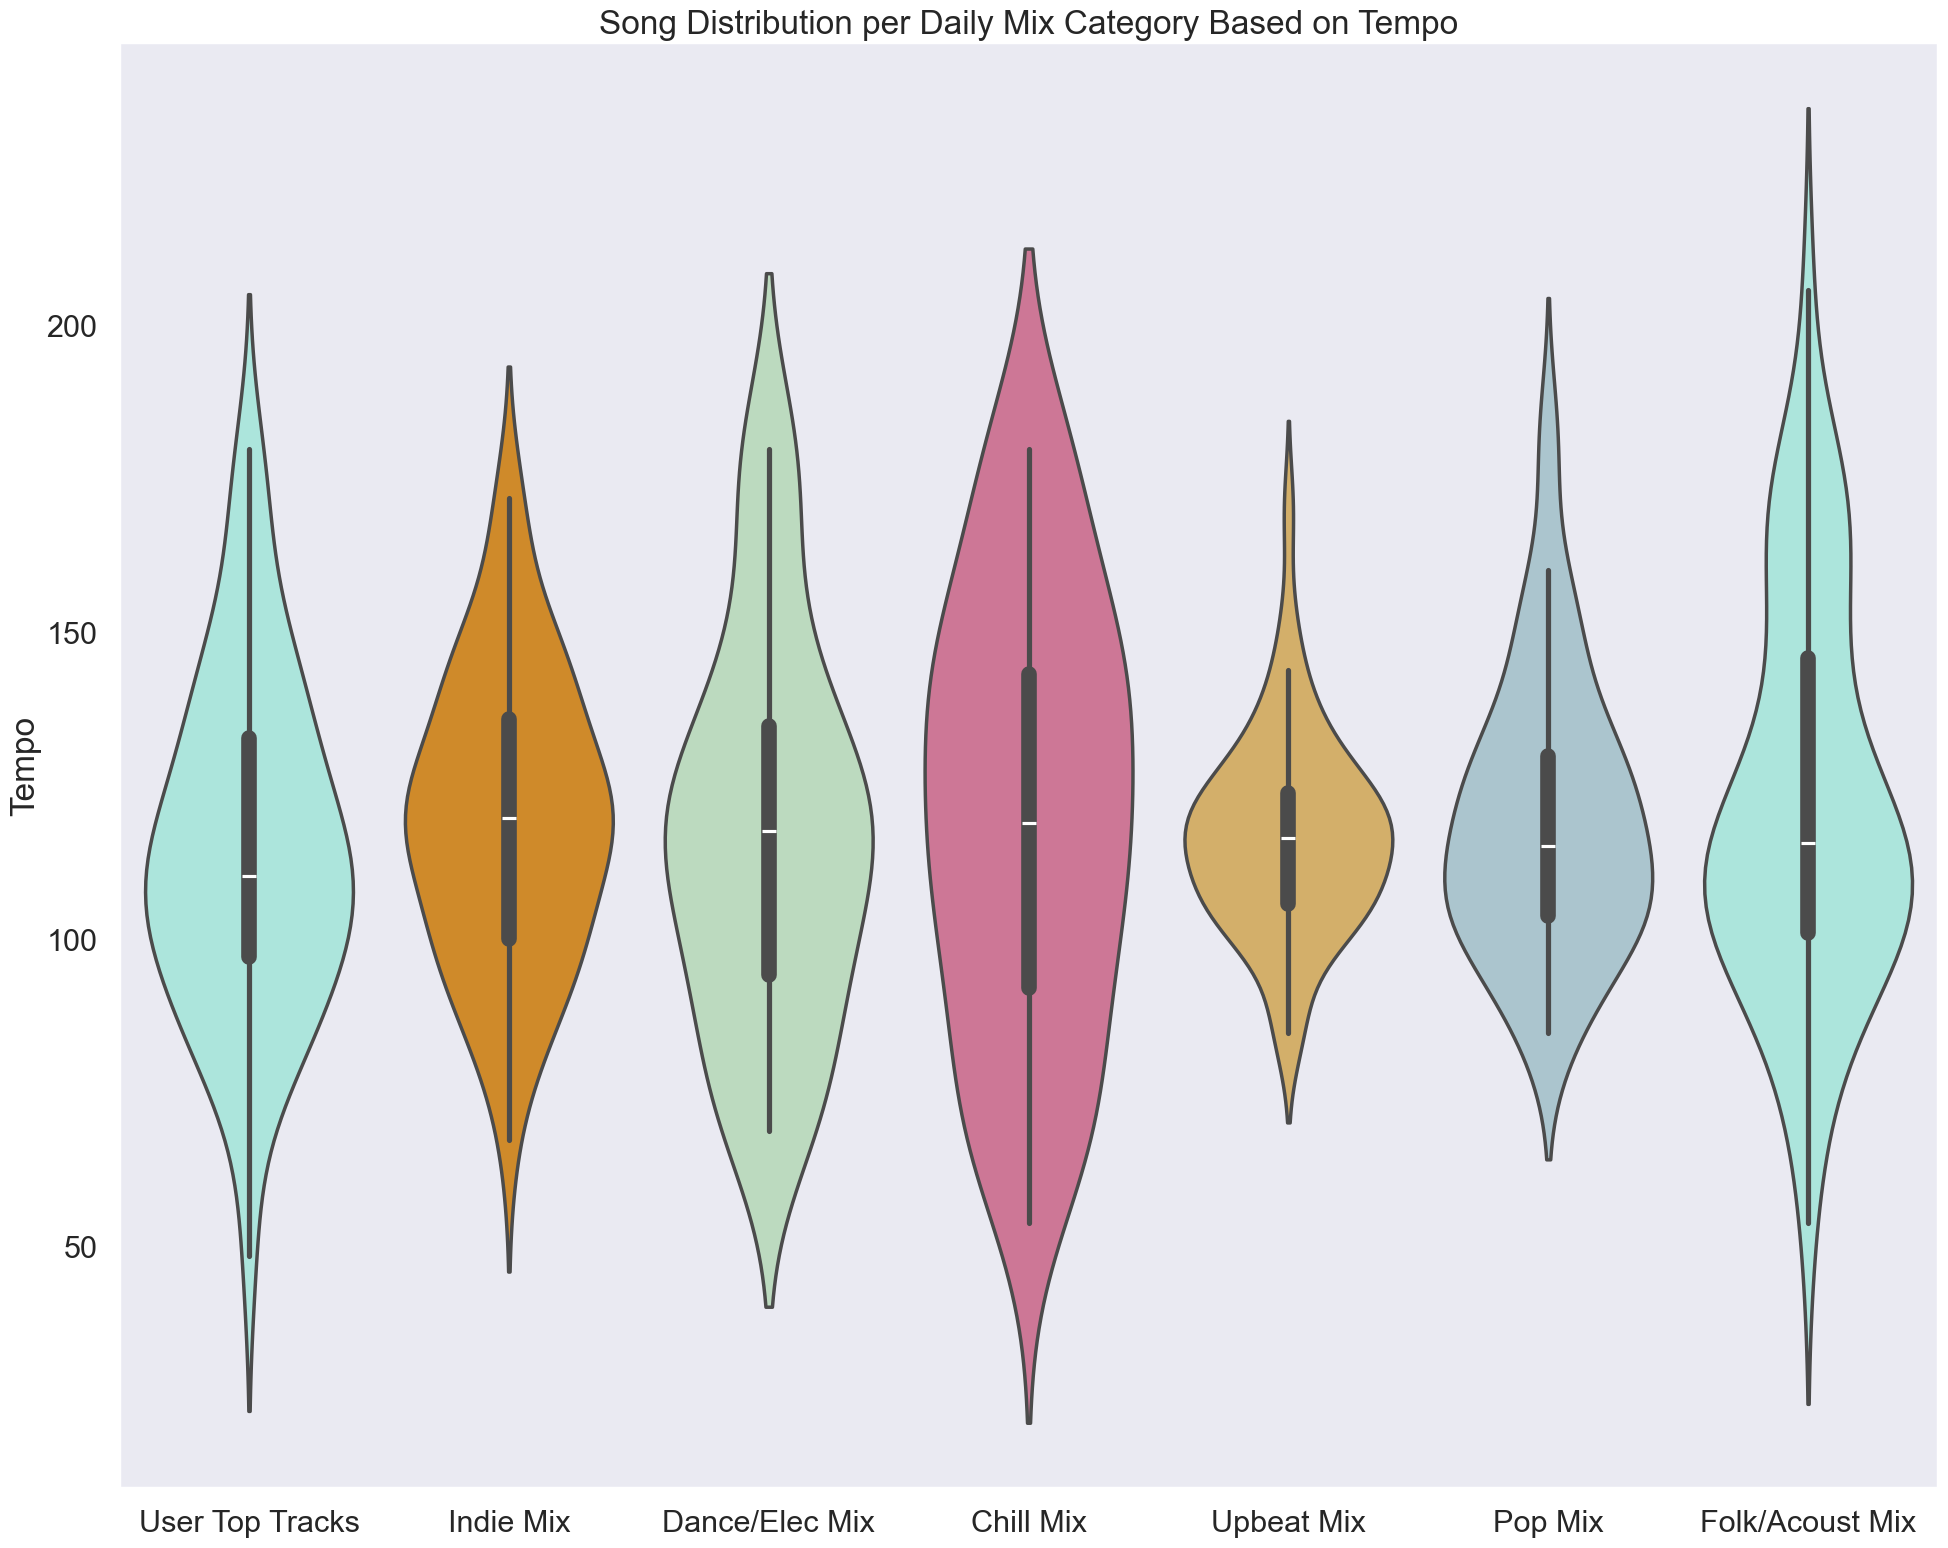

Tempo
Min: 48.637
Max: 206.016


In [5]:
# visualise data in violin plots
# https://medium.com/codex/decoding-spotify-daily-mix-73f4783037b4

cols = spotify_df.loc[:,'danceability':'tempo'].columns.to_list()
colors = ['#a3eee3', '#ea8e0f', '#b7dfbb', '#db6992', '#e4b459', '#a5c8d4']

for col in cols:
    fig, ax = plt.subplots(figsize=(20, 16))
    ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
    plt.title(f'Song Distribution per Daily Mix Category Based on {col.title()}')
    plt.ylabel(col.title())
    plt.xlabel(None)
    plt.tight_layout()
    plt.show()
    print('{}\nMin: {}\nMax: {}'.format(col.title(), min(spotify_df[col]), max(spotify_df[col])))

# Null: There is no significant difference between the user’s top tracks and the tracks in the daily mixes. Any variation is due to random chance.

# Alt: If there is a significant difference in the test scores, a large value is perhaps not random. One possibility is that Spotify intentionally picking things to create novelty.


In [6]:
# ANOVA test to compare select features, manually selected by me, across all data sets

anova_dance, anova_dance_p = scipy.stats.f_oneway(top_features_df['danceability'], indie_mix['danceability'], dance_electronic_mix['danceability'], chill_mix['danceability'], \
                        upbeat_mix['danceability'], pop_mix['danceability'], folk_acoustic_mix['danceability'])

anova_energy, anova_energy_p = scipy.stats.f_oneway(top_features_df['energy'], indie_mix['energy'], dance_electronic_mix['energy'], chill_mix['energy'], \
                        upbeat_mix['energy'], pop_mix['energy'], folk_acoustic_mix['energy'])

anova_acoustic, anova_acoustic_p = scipy.stats.f_oneway(top_features_df['acousticness'], indie_mix['acousticness'], dance_electronic_mix['acousticness'], chill_mix['acousticness'], \
                        upbeat_mix['acousticness'], pop_mix['acousticness'], folk_acoustic_mix['acousticness'])

# Build dataframe
d = {"ANOVA Score":[anova_dance,anova_energy,anova_acoustic], "P Value":[anova_dance_p,anova_energy_p,anova_acoustic_p]}
anova_index = ["Danceability", "Energy", "Acousticness"]
anova_df = pd.DataFrame(data=d, index=anova_index)
anova_df

# The z score is very high, and with the low p value this suggests there's some random chance introduced by Spotify when creating the mixes

,ANOVA Score,P Value
Danceability,20.573458,1.376305e-20
Energy,26.219777,1.156735e-25
Acousticness,25.849988,2.431911e-25


In [7]:
# Confirm p value scores and display
anova_alpha = 0.05

for index, p in anova_df["P Value"].items():
    if p <= anova_alpha:
        print(f"The P Value for the ANOVA test on {index} is below 0.05, which is statiscially significant.")
        print(f"The ANOVA is {anova_df.loc[index, 'ANOVA Score']}")
        print()
    else:
        print(f"The P Value for the ANOVA test on {index} is above 0.05, which is not statiscially significant.")
        print(f"The ANOVA is {anova_df.loc[index, 'ANOVA Score']}")
        print()

The P Value for the ANOVA test on Danceability is below 0.05, which is statiscially significant.
The ANOVA is 20.57345839972408

The P Value for the ANOVA test on Energy is below 0.05, which is statiscially significant.
The ANOVA is 26.219777235249033

The P Value for the ANOVA test on Acousticness is below 0.05, which is statiscially significant.
The ANOVA is 25.849988003369514



In [8]:
# T test on select data sets, manually selected by me, for the same select features

t_indie_dance, t_indie_dance_p = scipy.stats.ttest_ind(top_features_df['danceability'], indie_mix['danceability'])
t_indie_energy, t_indie_energy_p = scipy.stats.ttest_ind(top_features_df['energy'], indie_mix['energy'])
t_indie_acoustic, t_indie_acoustic_p = scipy.stats.ttest_ind(top_features_df['acousticness'], indie_mix['acousticness'])

t_upbeat_dance, t_upbeat_dance_p = scipy.stats.ttest_ind(top_features_df['danceability'], upbeat_mix['danceability'])
t_upbeat_energy, t_upbeat_energy_p = scipy.stats.ttest_ind(top_features_df['energy'], upbeat_mix['energy'])
t_upbeat_acoustic, t_upbeat_acoustic_p = scipy.stats.ttest_ind(top_features_df['acousticness'], upbeat_mix['acousticness'])

# Build dataframe
d = {"T Score":[t_indie_dance, t_indie_energy, t_indie_acoustic, t_upbeat_dance, t_upbeat_energy, t_upbeat_acoustic], \
     "P Value":[t_indie_dance_p, t_indie_energy_p, t_indie_acoustic_p, t_upbeat_dance_p, t_upbeat_energy_p, t_upbeat_acoustic_p]}
t_index = ["Indie Danceability", "Indie Energy", "Indie Acousticness", "Upbeat Danceability", "Upbeat Energy", "Upbeat Acousticness"]

t_df = pd.DataFrame(data=d, index=t_index)
t_df

# The T scores for the Indie category are much lower on average than the Upbeat category
# Yet for a small T score, the P Value can be high, and for a larger T score, the P Value may be quite low
# Once again this is suggesting built in randomness

,T Score,P Value
Indie Danceability,-2.910622,4.465015e-03
Indie Energy,-1.956052,5.330610e-02
Indie Acousticness,-0.515548,6.073311e-01
Upbeat Danceability,-7.768563,7.881566e-12
Upbeat Energy,-6.256453,1.036904e-08
Upbeat Acousticness,3.276788,1.452878e-03


In [9]:
# Confirm p value scores and display

t_alpha = 0.05

for index, p in t_df["P Value"].items():
    if p <= t_alpha:
        print(f"The P Value for the T Test on {index} is below 0.05, which is statiscially significant.")
        print(f"The T Score is {t_df.loc[index, 'T Score']}")
        print()
    elif p > t_alpha:
        print(f"The P Value for the T Test test on {index} is above 0.05, which is not statiscially significant.")
        print(f"The T Score is {t_df.loc[index, 'T Score']}")
        print()

The P Value for the T Test on Indie Danceability is below 0.05, which is statiscially significant.
The T Score is -2.910622481521359

The P Value for the T Test test on Indie Energy is above 0.05, which is not statiscially significant.
The T Score is -1.956051587506442

The P Value for the T Test test on Indie Acousticness is above 0.05, which is not statiscially significant.
The T Score is -0.5155481358688437

The P Value for the T Test on Upbeat Danceability is below 0.05, which is statiscially significant.
The T Score is -7.7685626727623385

The P Value for the T Test on Upbeat Energy is below 0.05, which is statiscially significant.
The T Score is -6.2564534608668

The P Value for the T Test on Upbeat Acousticness is below 0.05, which is statiscially significant.
The T Score is 3.276787846904541



In [10]:
# Running Pearson Regression, although I'm not convinced this is an appropriate test

pear_indie_dance, pear_indie_dance_p = scipy.stats.pearsonr(top_features_df['danceability'], indie_mix['danceability'])
pear_indie_energy, pear_indie_energy_p = scipy.stats.pearsonr(top_features_df['energy'], indie_mix['energy'])
pear_indie_acoustic, pear_indie_acoustic_p = scipy.stats.pearsonr(top_features_df['acousticness'], indie_mix['acousticness'])

pear_upeat_dance, pear_upbeat_dance_p = scipy.stats.pearsonr(top_features_df['danceability'], upbeat_mix['danceability'])
pear_upbeat_energy, pear_upbeat_energy_p = scipy.stats.pearsonr(top_features_df['energy'], upbeat_mix['energy'])
pear_upbeat_acoustic, pear_upbeat_acoustic_p = scipy.stats.pearsonr(top_features_df['acousticness'], upbeat_mix['acousticness'])

# Build dataframe
d = {"Pearson R Score":[pear_indie_dance, pear_indie_energy, pear_indie_acoustic, pear_upeat_dance, pear_upbeat_energy, pear_upbeat_acoustic], \
     "P Value":[pear_indie_dance_p, pear_indie_energy_p, pear_indie_acoustic_p, pear_upbeat_dance_p, pear_upbeat_energy_p, pear_upbeat_acoustic_p]}
pear_index = ["Indie Danceability", "Indie Energy", "Indie Acousticness", "Upbeat Danceability", "Upbeat Energy", "Upbeat Acousticness"]

pear_df = pd.DataFrame(data=d, index=pear_index)
pear_df

,Pearson R Score,P Value
Indie Danceability,0.024543,0.865653
Indie Energy,-0.041358,0.775513
Indie Acousticness,-0.048103,0.740095
Upbeat Danceability,-0.036797,0.799726
Upbeat Energy,-0.165771,0.249933
Upbeat Acousticness,-0.189392,0.187742


In [11]:
# Confirm p value scores and display
pear_alpha = 0.05

for index, p in pear_df["P Value"].items():
    if p <= pear_alpha:
        print(f"The P Value for the Pearson Regression on {index} is below 0.05, which is statiscially significant.")
        print(f"The R Value is {pear_df.loc[index, 'Pearson R Score']}")
        print()
    elif p > pear_alpha:
        print(f"The P Value for the Pearson Regression test on {index} is above 0.05, which is not statiscially significant.")
        print(f"The R Value is {pear_df.loc[index, 'Pearson R Score']}")
        print()

# This test doesn't appear to produce useful results, as there's very little correlation and no statistical significance

The P Value for the Pearson Regression test on Indie Danceability is above 0.05, which is not statiscially significant.
The R Value is 0.02454328266029683

The P Value for the Pearson Regression test on Indie Energy is above 0.05, which is not statiscially significant.
The R Value is -0.041358106138417616

The P Value for the Pearson Regression test on Indie Acousticness is above 0.05, which is not statiscially significant.
The R Value is -0.048102786220563895

The P Value for the Pearson Regression test on Upbeat Danceability is above 0.05, which is not statiscially significant.
The R Value is -0.03679747574538518

The P Value for the Pearson Regression test on Upbeat Energy is above 0.05, which is not statiscially significant.
The R Value is -0.16577097014612605

The P Value for the Pearson Regression test on Upbeat Acousticness is above 0.05, which is not statiscially significant.
The R Value is -0.18939168855775487



In [12]:
# Begin track recommendation
# get The Weeknd data

sp = spotipy.Spotify(auth_manager=SpotifyOAuth())

# search API using artist name
artist_name = 'The Weeknd'
artist_id = ""
results = sp.search(q=f'artist:{artist_name}', type='artist', limit=1)

if results['artists']['items']:
    artist_id = results['artists']['items'][0]['id']
    sp.artist_top_tracks(artist_id)
else:
    print(f"No artist found with the name '{artist_name}'")

# Get top 10 track ids
top_weeknd = sp.artist_top_tracks(artist_id)

top_weeknd_track_ids = []

# get features using ids
for i in top_weeknd['tracks']:
    top_weeknd_track_ids.append(i['id'])

# Build features dataframe
top_weeknd_features = sp.audio_features(top_weeknd_track_ids)
top_weeknd_df = pd.DataFrame(data=top_weeknd_features, columns=top_weeknd_features[0].keys())
top_weeknd_features_df = top_weeknd_df.drop(columns=["type", "id","uri","track_href", "analysis_url", "time_signature"])

# Standardise data with Z scores
features_z_score = scipy.stats.zscore(top_features_df.drop(columns='source').iloc[:10]) # Only using top 10 for congruency
top_weeknd_z_scores = scipy.stats.zscore(top_weeknd_features_df)
top_weeknd_z_scores.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-1.351575,0.107771,1.6855,0.429969,1.0,-0.745804,-0.593710,-0.333939,-0.195169,-0.885742,-1.046234,0.774647
1,0.223757,-0.446478,1.3484,0.052612,1.0,2.476512,0.057882,-0.333710,-0.364058,0.404262,2.047343,0.406637
2,1.989736,0.487533,-0.6742,0.435671,1.0,1.328512,-0.575631,-0.332607,1.493727,2.066730,-0.684433,0.019130
3,-1.431847,1.021254,-0.6742,0.612946,1.0,-0.376333,-0.993252,-0.330493,-0.683598,-0.286163,1.576269,-0.379781
4,-0.709401,-1.082838,-0.6742,-0.024103,-1.0,-0.353900,-0.168103,-0.333939,-0.384325,0.504191,0.402322,1.177203


In [13]:
# Using cosine similarity to find most similar track
# Inspired by source, but they used more complex methods to prepare the data before applying the cosine similarity
# https://towardsdatascience.com/part-iii-building-a-song-recommendation-system-with-spotify-cf76b52705e7
# Also used ChatGPT for help

# Create matrix using cosine similarity function
similarity_matrix = cosine_similarity(top_weeknd_z_scores.values, features_z_score.values)

# build dataframe for display
similarity_df = pd.DataFrame(similarity_matrix, index=top_weeknd_z_scores.index, columns=features_z_score.index)
similarity_df

,0,1,2,3,4,5,6,7,8,9
0,0.153647,-0.100868,-0.088900,-0.284247,0.177419,0.547879,0.225539,-0.036782,-0.616390,0.204620
1,0.402101,-0.262322,-0.255256,0.210272,0.123630,-0.208126,-0.020619,0.376442,0.049501,-0.502087
2,-0.122630,-0.255833,0.015568,0.206217,-0.440012,-0.225308,-0.162235,0.502341,0.567624,-0.006296
3,0.589635,-0.106175,-0.273008,-0.357188,-0.001530,0.404514,-0.096364,0.276595,-0.126206,-0.033196
4,0.144072,-0.073902,-0.191192,0.149430,-0.176201,0.034012,0.134174,-0.326447,0.066837,0.199747
5,-0.522558,0.457095,0.185955,0.394205,0.683569,-0.675209,-0.256042,-0.557009,0.055456,-0.221833
6,0.119960,-0.401715,0.280017,-0.269796,-0.489835,0.208302,0.034956,0.302678,0.213802,0.206813
7,-0.322536,0.406763,0.263235,-0.135957,-0.337470,0.043581,-0.026239,-0.212431,-0.048910,0.507025
8,-0.150868,0.287781,-0.108203,0.026373,-0.054031,0.362283,0.238673,-0.343011,-0.375437,0.179432
9,0.118062,-0.102270,-0.127394,-0.415042,0.126486,0.360543,0.421124,0.074626,-0.184547,-0.294974


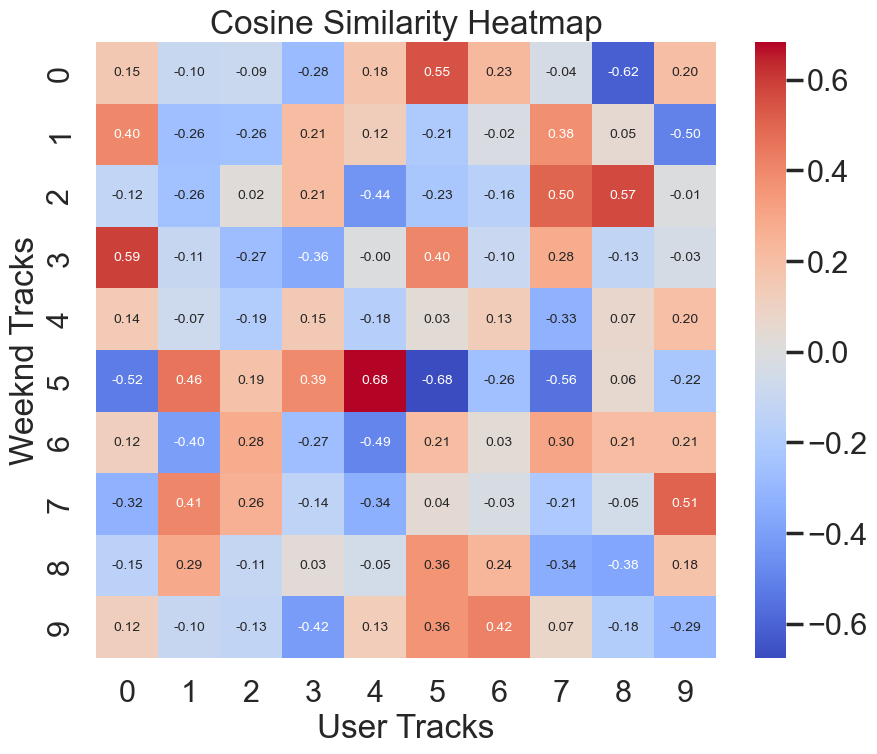

In [22]:
# Create heatmap to visualise similarity data

plt.figure(figsize=(10, 8))
# Create heatmap
sns.heatmap(similarity_df, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"fontsize": 10})
plt.title('Cosine Similarity Heatmap')
plt.xlabel('User Tracks')
plt.ylabel('Weeknd Tracks')
plt.show()

In [15]:

# Find the best similarity for each track in top_weeknd_z_scores
best_similarity = similarity_matrix.max(axis=1)

# Add the best similarity as a new column in top_weeknd_z_scores
top_weeknd_df['best_similarity'] = best_similarity

# Display the updated DataFrame
top_weeknd_df_sorted = top_weeknd_df.sort_values(by='best_similarity', ascending=False)
top_weeknd_df_sorted.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,best_similarity
5,0.715,0.470,5,-12.638,0,0.0772,0.35300,0.092300,0.1040,0.426,89.965,audio_features,5gDWsRxpJ2lZAffh5p7K0w,spotify:track:5gDWsRxpJ2lZAffh5p7K0w,https://api.spotify.com/v1/tracks/5gDWsRxpJ2lZ...,https://api.spotify.com/v1/audio-analysis/5gDW...,111627,4,0.683569
3,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,0.589635
2,0.855,0.678,1,-6.276,1,0.1890,0.05690,0.000037,0.4120,0.852,99.029,audio_features,6WzRpISELf3YglGAh7TXcG,spotify:track:6WzRpISELf3YglGAh7TXcG,https://api.spotify.com/v1/tracks/6WzRpISELf3Y...,https://api.spotify.com/v1/audio-analysis/6WzR...,215467,4,0.567624
0,0.522,0.641,8,-6.287,1,0.0318,0.05450,0.000000,0.1620,0.202,87.510,audio_features,7CyPwkp0oE8Ro9Dd5CUDjW,spotify:track:7CyPwkp0oE8Ro9Dd5CUDjW,https://api.spotify.com/v1/tracks/7CyPwkp0oE8R...,https://api.spotify.com/v1/audio-analysis/7CyP...,244685,4,0.547879
7,0.715,0.620,1,-6.005,0,0.0484,0.41700,0.000000,0.0822,0.172,97.950,audio_features,2dHHgzDwk4BJdRwy9uXhTO,spotify:track:2dHHgzDwk4BJdRwy9uXhTO,https://api.spotify.com/v1/tracks/2dHHgzDwk4BJ...,https://api.spotify.com/v1/audio-analysis/2dHH...,221520,4,0.507025


In [16]:
# Sort and check top track
top_weeknd_df_sorted.reset_index(drop=True, inplace=True)
top_weeknd_df_sorted.loc[0:0, ["id", "best_similarity"]]

,id,best_similarity
0,5gDWsRxpJ2lZAffh5p7K0w,0.683569


In [17]:
# Retrieve name from Spotify API
weeknd_track_id = top_weeknd_df_sorted.loc[0:0, "id"]
weeknd_track_info = sp.track(weeknd_track_id[0])
weeknd_track_name = weeknd_track_info['album']['name']
weeknd_track_name


'Starboy'